In [2]:
import numpy as np
import pandas as pd
import math
import os
import torch
import torch.nn as nn
from torch.optim import Adam, RMSprop
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import torch.nn.functional as F
from collections import deque
from sklearn import metrics
from functools import wraps
from time import time
import ot
from pathlib import Path
import time

n = 1000
x_dim = 3
hiddens = [x_dim + 1, 32, 64, 1]
test_size = 0.2
valid_size = 0.125
batch_size = 100
seq_len = 10
epsilon = 0.5
eps = str(epsilon).replace(".", "_")
b = 0.2
bet = str(0.2).replace(".", "_")
l = 0.1
c_hiddens = [x_dim + 1, 32, 64, 1]
g_hidden_size = 64
g_num_layers = 2
d_hidden_size = 64
d_num_layers = 2
gan_epochs = 500
train_vaca = 0
dataset = 'taiwan'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
# device = torch.device('cpu')
print(device)

res_path = Path('../res')
log_dir = res_path / f'taiwan'
clf_path = log_dir / (f"c_model_" + ".pth")
efforts_path = log_dir / (f"effort_model" + ".pth")
gan_path = log_dir / (f"gan_model_taiwan_"  + str(gan_epochs) + "_" + str(g_hidden_size) + "_eps_" +eps+"_b_" + bet + ".pth")
re_clf_path = log_dir / (f"dp_model-" + str(6)+ ".pth")
tsne_path = log_dir / (f"syn-tsne.png")

cuda:0


In [3]:
def tensor(x):
    return torch.FloatTensor(x)

def to_tensor(z, x, y=None):
    if torch.is_tensor(x):
        zx = torch.cat([z, x], dim=1)
    else:
        zx = np.concatenate([z, x], axis=1)
        zx = torch.FloatTensor(zx)
    if isinstance(y, np.ndarray):
        y = torch.FloatTensor(y)
        return zx, y
    return zx

class TrueModel(nn.Module):

    def __init__(self, hiddens, seed=0):
        super().__init__()
        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
        layers.pop()
        layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def forward(self, zx):
        return self.model(zx)

    def predict(self, z, x):
        zx = to_tensor(z, x)
        pred = self(zx)
        pred_y = pred.detach().round().cpu().numpy()
        return pred_y

    def fit(self, z, x, y, patience=10):
        zx = to_tensor(z, x)
        y = tensor(y)

        epoch, counter = 0, 0
        best_loss = float('inf')
        while True:
            pred = self(zx)
            loss = self.loss_fn(pred, y)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            epoch += 1
            if loss.item() <= best_loss:
                best_loss = loss.item()
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
        #print(f"TrueModel Fit Done in {epoch} epochs!")

    def sample(self, s, x, scale=0.8):
        sx = to_tensor(s, x)
        prob = self(sx)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

In [4]:
def demographic_parity(sensi, pred_y):

    s0 = sum(sensi.squeeze() == 0)
    s1 = sum(sensi.squeeze() == 1)
    y0 = sum(pred_y.squeeze() == 0)
    y1 = sum(pred_y.squeeze() == 1)
    y1_s0 = sum(pred_y[sensi.squeeze() == 0].squeeze() == 1) / s0
    y1_s1 = sum(pred_y[sensi.squeeze() == 1].squeeze() == 1) / s1
    print(f"#(S=0): {s0}, #(S=1): {s1}, #(y0): {y0}, #(y1): {y1}, P(y=1|s=0)={y1_s0:.3f}, P(y=1|s=1)={y1_s1:.3f}")
    return y1_s1 - y1_s0

In [5]:
def count_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time()
        result = func(*args, **kwargs)
        end_time = time()
        duration = end_time - start_time
        print(f"Time: {duration:5.2f}s")
        return result
    return wrapper

class Classifier(nn.Module):

    def __init__(self, hiddens, dropout_prob = 0.2):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.Dropout(p=dropout_prob))
        layers.pop()
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

        self.dropout_prob = dropout_prob

    def get_params(self):
        params = []
        for param in self.parameters():
            params.append(param.detach().cpu().flatten().numpy())
        return np.hstack(params)

    def forward(self, s_mb, x_mb, num_samples = 10):
        pred = []

        for _ in range(num_samples):
            sx_mb = torch.cat([s_mb, x_mb], dim=1)
            output = self.model(sx_mb)
            pred.append(output.unsqueeze(0))  # Add the unsqueezed prediction
        return  torch.mean(torch.cat(pred, dim=0), dim=0)

    def predict(self, s_mb, x_mb):
        probs = self(s_mb, x_mb)
        pred_y = probs.detach().round().cpu().numpy()
        return pred_y

    def sample(self, s, x, scale=1.0):
        prob = self(s, x)
        y = torch.bernoulli(prob * scale)
        return y.detach().cpu().numpy()

    # @count_time
    def fit(self, loader, valid_loader, save_path, device, max_epochs = 300, patience=20):
        epoch, counter = 0, 0
        best_loss = float('inf')

        while epoch < max_epochs:
            loss = 0.
            for s_mb, x_mb, y_mb in loader:
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                batch_loss = 0.
                for i in range(x_mb.size(1)):
                    pred_y_mb = self(s_mb, x_mb[:, i])
                    batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                self.optim.zero_grad()
                batch_loss.backward()
                self.optim.step()

            epoch += 1
            valid_loss = self.eval(valid_loader, device)
            if valid_loss <= best_loss:
                # torch.save(self.state_dict(), save_path)
                best_loss = valid_loss
                counter = 0
            else:
                counter += 1
                if counter == patience:
                    break
            
            if epoch == 1 or epoch % 100 == 0:
                print(f'{epoch:6.0f} | loss: {loss:6.4f}')
        print(f"Classifier Fit Done in {epoch} epochs!, Counter: {counter}")

    def eval(self, loader, device, verbose=False):
        loss = 0.
        for s_mb, x_mb, y_mb in loader:
            s_mb = s_mb.to(device)
            x_mb = x_mb.to(device)
            y_mb = y_mb.to(device)

            batch_loss = 0.
            for i in range(x_mb.size(1)):
                s_mb = s_mb.to(device)
                x_mb = x_mb.to(device)
                y_mb = y_mb.to(device)

                pred_y_mb = self(s_mb, x_mb[:, i].to(device))
                batch_loss += self.loss_fn(pred_y_mb, y_mb[:, i])
                loss += batch_loss.item()

                if verbose:
                    pred_y_mb = self.predict(s_mb, x_mb[:, i])
                    true_y_mb = y_mb[:, i].cpu().numpy()
                    s_mb_np = s_mb.cpu().numpy()

                    acc = metrics.accuracy_score(true_y_mb, pred_y_mb) * 100
                    fair = demographic_parity(s_mb_np, pred_y_mb)
                    print(f"Step: {i:6.0f}, ACC: {acc:6.2f}%, FAIR: {fair:6.2f}\n")
        return loss

In [6]:
class NaiveCLF(nn.Module):
    def __init__(self, x_dim):
        super().__init__()
        self.linear = nn.Linear(x_dim, 1)
        self.loss_fn = nn.BCELoss()
        self.optim = Adam(self.parameters())

    def forward(self, s, x):
        return torch.round(torch.sigmoid(self.linear(x)))
    
    def prob(self, s, x):
        return torch.sigmoid(self.linear(x))
    
    def fit(self, s, x, y, patience=10):
        x = tensor(x)
        y = tensor(y)

        epoch, counter = 0, 0
        best_loss = float('inf')
        while True:
            pred = self(s, x)
            loss = self.loss_fn(pred, y)

            self.optim.zero_grad()
            loss.backward()
            self.optim.step()
            
            epoch += 1
            if epoch % 100 == 0:
                print(f"Epoch: {epoch}, Loss: {loss.item()}")

            if loss.item() < best_loss:
                best_loss = loss.item()
                counter = 0
            else:
                counter += 1
                if counter == patience or epoch >= 5000:
                    
                    break
#         print(f"TrueModel Fit Done in {epoch} epochs!")

In [7]:
def compute_distance_loss(data, check_divergence = False):
    pos_data = data[data[:, 0] == 1, 1:]
    neg_data = data[data[:, 0] == 0, 1:]
    w1 = torch.ones(len(pos_data)) / len(pos_data)
    w2 = torch.ones(len(neg_data)) / len(neg_data)
    M = ot.dist(pos_data, neg_data)
    loss = sinkhorn_distance(pos_data, neg_data, check_divergence)
    # loss = ot.sinkhorn2(w1, w2, M, 0.1)
    return loss


def sinkhorn_distance(data1, data2, check_divergence, epsilon = 0.1, num_iters = 100, tol=1e-3):
    n, m = data1.shape[0], data2.shape[0]
    a = torch.ones(n) / n
    b = torch.ones(m) / m
    a.to(device)
    b.to(device)

    C = torch.cdist(data1, data2, p=2) ** 2
    C = C / C.max()

    K = torch.exp(-C / epsilon) 
    K.to(device)

    u = torch.ones(n).to(device)
    v = torch.ones(m).to(device)

    for i in range(num_iters):
        
        u_prev = u.clone()
        v_prev = v.clone()
        u = a.to(device) / (K.to(device) @ v.to(device) + 1e-8)
        v = b.to(device) / (torch.transpose(K, 0, 1).to(device) @ u.to(device) + 1e-8)

        if check_divergence:
            u_change = torch.norm(u - u_prev)
            v_change = torch.norm(v - v_prev)
            if u_change < tol and v_change < tol:
                print(f"Converged in {i} iterations")
                break

    plan = torch.diag(u) @ K @ torch.diag(v)
    distance = torch.sum(plan * C).to(device)
    return distance

In [8]:
def gen_gaussian(sample_size, seed=0):

    torch.manual_seed(seed)
    np.random.seed(seed)
    
    mu0, sigma0 = [-1, -1], [[5, 1], [1, 5]]
    mu1, sigma1 = [1, 1], [[5, 1], [1, 5]]
    s0 = np.ones(sample_size, dtype=float) * 0
    X0 = np.random.multivariate_normal(mean=mu0, cov=sigma0, size=sample_size)
    s1 = np.ones(sample_size, dtype=float) * 1
    X1 = np.random.multivariate_normal(mean=mu1, cov=sigma1, size=sample_size)

    s = np.concatenate((s0, s1))
    X = np.vstack((X0, X1))
    perm = list(range(int(2*sample_size)))
    np.random.shuffle(perm)
    s = s[perm]
    X = X[perm]
    y=np.random.binomial(1, 1/(1+np.exp(-(X[:,0]+2*X[:,1]-1))))

    return s, X, y

def sequential_data(s0, x0, y0, seq_len, l=0.5, noise_factor = 1, b = 0.5, seed=0, ground_truth = True):
    torch.manual_seed(seed)
    np.random.seed(seed)
    l_og = l
    n = len(s0)
    model = NaiveCLF(x0.shape[1])
    x_dim = x0.shape[1]
    hiddens = [x_dim + 1, 32, 64, 1]
    true_model = TrueModel(hiddens)
    true_model.fit(s0.reshape(-1,1), x0, y0.reshape(-1,1))
    x0 = torch.from_numpy(x0).to(dtype=torch.float32)
    x0.requires_grad = True
    y0 = torch.from_numpy(y0).to(dtype=torch.float32)
    model.fit(s0, x0, y0.view(n, 1))
    theta_t = abs(model.optim.param_groups[0]['params'][-1].item())

    
    x = torch.empty(n, seq_len, x0.shape[1])
    y= torch.empty(n, seq_len, 1)
    x[:, 0, :] = x0
    y[:, 0, :] = y0.view(n, 1)

    prevy = y0
    
    for i in range(1, seq_len):
        yhat = model(s0, x[:,i-1,:])
        for j in range(n):
            
            if yhat[j] == 1 and prevy[j] == 0:
                l = -l_og
            elif yhat[j] == 1 and prevy[j] == 1:
                l = l_og
            else:
                l = 0
            for k in range(x0.shape[1]):
                x[j, i, k] = np.random.randn()*noise_factor + x[j, i-1, k] + l*theta_t + s0[j]*b + (1-s0[j])*0.1
        if ground_truth:
            y[:, i, :] = torch.bernoulli((1 /(1+  torch.exp(-(x[:,i,0]+3*x[:,i,1]-1))))).view(n, 1)
        else:
            y[:, i, :] = tensor(true_model.sample(tensor(s0.reshape(-1,1)), x[:, i, :]))
        prevy = y[:, i, :]
        

    # x = np.array(x, dtype=np.float32).reshape((n, seq_len, 2))
    #y = np.array(y, dtype=np.int32).reshape(n, seq_len, 1)
    return x, y, model

s0, x0, y0 = gen_gaussian(int(n/2), seed=52)
x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=epsilon, noise_factor=0.1, b=b, seed=52, ground_truth=False)

In [9]:
def sample_taiwan(file_path, n, seq_len, seed=0):

    df = pd.read_excel(file_path, header=1)
    torch.manual_seed(seed)
    np.random.seed(seed)
    df = df[(df['PAY_AMT1'] < 10000) & (df['PAY_AMT1'] > 10)]
    df = df[(df['PAY_AMT2'] < 10000) & (df['PAY_AMT2'] > 10)]
    df = df[(df['PAY_AMT3'] < 10000) & (df['PAY_AMT3'] > 10)]

    label0 = df[(df['default payment next month'] == 1) & (df['SEX'] == 1)].sample(n=n, replace=False, random_state=seed)
    label1 = df[(df['default payment next month'] == 0) & (df['SEX'] == 1)].sample(n=n, replace=False, random_state=seed)
    label2 = df[(df['default payment next month'] == 1) & (df['SEX'] == 2)].sample(n=n, replace=False, random_state=seed)
    label3 = df[(df['default payment next month'] == 0) & (df['SEX'] == 2)].sample(n=n, replace=False, random_state=seed)

    df = pd.concat([label0, label1, label2, label3], axis=0)
    X = df.iloc[:, 18:20].apply(lambda x: 3 * (x - x.mean()) / (x.max() - x.min()))
    Z = df.iloc[:, 1:2].apply(lambda x: 3 * (x - x.mean()) / (x.max() - x.min()))
    S = df['SEX'] - 1
    Y = df['default payment next month'].replace({0: 1, 1: 0})
    data = pd.concat([S, Z, X, Y], axis=1)

    data = data.rename(columns={'default payment next month': 'y'})
    s0 = S.to_numpy()
    x0 = pd.concat([Z, X], axis=1).to_numpy()
    y0 = Y.to_numpy()
    _, _, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=0.1, noise_factor=0.01, b = 0.01, seed=seed, ground_truth=False)

    return s0, x0, y0, unfair_clf

In [10]:
data_path = Path('../data')
file_path = '/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/SimLoan/data/default of credit card clients.xls'
df = pd.read_excel(file_path, header=1)
df = df[(df['PAY_AMT1'] < 10000) & (df['PAY_AMT1'] > 10)]
df = df[(df['PAY_AMT2'] < 10000) & (df['PAY_AMT2'] > 10)]
df = df[(df['PAY_AMT3'] < 10000) & (df['PAY_AMT3'] > 10)]

label0 = df[(df['default payment next month'] == 1) & (df['SEX'] == 1)].sample(n=int(n/4), replace=False, random_state=2021)
label1 = df[(df['default payment next month'] == 0) & (df['SEX'] == 1)].sample(n=int(n/4), replace=False, random_state=2021)
label2 = df[(df['default payment next month'] == 1) & (df['SEX'] == 2)].sample(n=int(n/4), replace=False, random_state=2021)
label3 = df[(df['default payment next month'] == 0) & (df['SEX'] == 2)].sample(n=int(n/4), replace=False, random_state=2021)

df = pd.concat([label0, label1, label2, label3], axis=0)
X = df.iloc[:, 18:20].apply(lambda x: 3 * (x - x.mean()) / (x.max() - x.min()))
Z = df.iloc[:, 1:2].apply(lambda x: 3 * (x - x.mean()) / (x.max() - x.min()))
S = df['SEX'] - 1
Y = df['default payment next month'].replace({0: 1, 1: 0})
data = pd.concat([S, Z, X, Y], axis=1)

data = data.rename(columns={'default payment next month': 'y'})


In [11]:
s0 = S.to_numpy()
x0 = pd.concat([Z, X], axis=1).to_numpy()
y0 = Y.to_numpy()
x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=epsilon, noise_factor=0.01, b = b, seed=52, ground_truth=False)

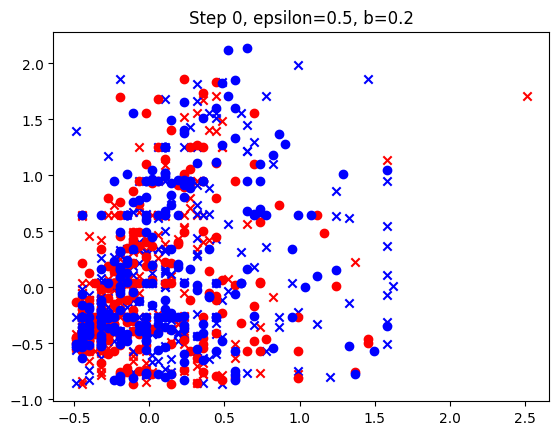

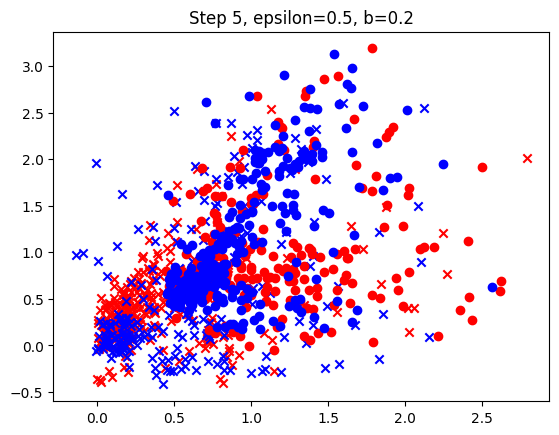

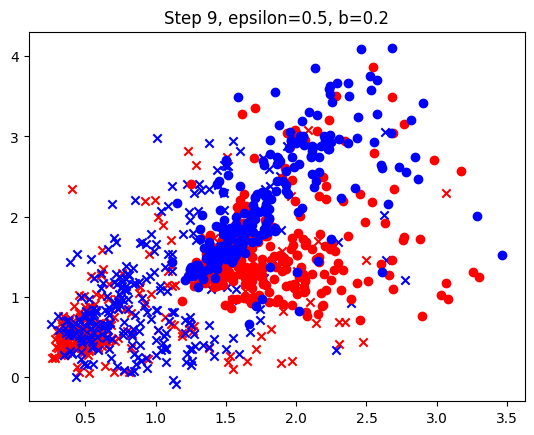

In [12]:
steps = [0, 5, 9]

for i in steps:
    x_neg = x[s0 == 0, i, :].detach().cpu().numpy()
    y_neg = y[s0 == 0, i, :].detach().cpu().numpy()
    y_neg = y_neg.squeeze()
    x_pos = x[s0 == 1, i, :].detach().cpu().numpy()
    y_pos = y[s0 == 1, i, :].detach().cpu().numpy()
    y_pos = y_pos.squeeze()

    plt.scatter(x_neg[y_neg==0, 0], x_neg[y_neg==0, 1], marker='x', color='red')
    plt.scatter(x_neg[y_neg==1, 0], x_neg[y_neg==1, 1], marker='x', color='blue')
    plt.scatter(x_pos[y_pos==0, 0], x_pos[y_pos==0, 1], marker='o', color='red')
    plt.scatter(x_pos[y_pos==1, 0], x_pos[y_pos==1, 1], marker='o', color='blue')
    plt.title(f"Step {i}, epsilon={epsilon}, b={b}")
    plt.show()

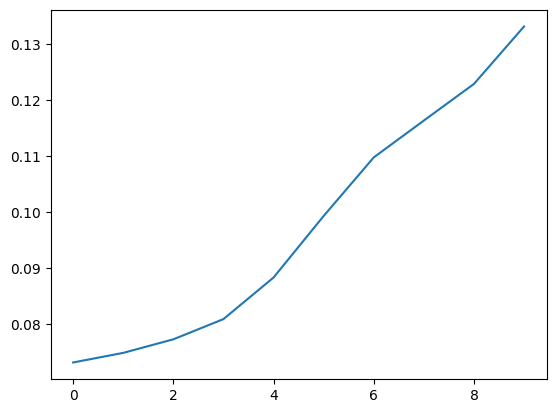

In [13]:
f_og = []
s_og = tensor(s0).view(len(s0), 1)
data = torch.empty(len(s0), seq_len, x0.shape[1] + 2)
for i in range(seq_len):
    x_og = x[:, i, :]
    y_og = y[:, i, :]
    data[:, i] = torch.cat([s_og.to(device), x_og.to(device), y_og.to(device)], dim=1)
    distance = compute_distance_loss(data[:, i].to(device))
    f_og.append(distance.item())

plt.plot(f_og)

In [14]:
x = x.detach().numpy()
y = y.detach().numpy()
y = y.astype(int)
s0 = np.array(s0).reshape(len(s0),1)
s_train, s_test, x_train, x_test, y_train, y_test = train_test_split(s0, x, y, test_size=test_size, random_state=10)
s_train, s_valid, x_train, x_valid, y_train, y_valid = train_test_split(s_train, x_train, y_train, test_size=valid_size, random_state=10)
print(x_train.shape)


(700, 10, 3)


In [15]:
class Generator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).to(device).scatter_(1, s0.long(), torch.ones_like(s0))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            # xt = self.sigmoid(self.linear(output).squeeze())
            xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round().detach()
    
class Discriminator(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.rnn = nn.GRU(in_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output, hn = self.rnn(x)
        output = self.linear(output)
        output = self.sigmoid(output)
        return output

class DistributionDiscriminator(nn.Module):

    def __init__(self, hiddens):
        super().__init__()

        layers = []
        for in_dim, out_dim in zip(hiddens[:-1], hiddens[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(nn.LeakyReLU(0.2))
        layers.pop()
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        output = self.model(x)
        return output

In [16]:
generator = Generator(x_dim, g_hidden_size, g_num_layers)
generator.to(device)
discriminator = Discriminator(x_dim, d_hidden_size, d_num_layers)
discriminator.to(device)
clf = Classifier(c_hiddens, dropout_prob=0.2)
clf.to(device)

Classifier(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=64, out_features=1, bias=True)
    (7): ReLU(inplace=True)
    (8): Sigmoid()
  )
  (loss_fn): BCELoss()
)

In [17]:
from torch.optim import Adam, RMSprop
from torch.utils.data import DataLoader, TensorDataset


def train_discriminator(clf, G, D, optim, loss_fn, xs, zs, ss):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake.detach())
    loss_fake = loss_fn(fake, torch.zeros_like(fake))

    real = D(xs)
    loss_real = loss_fn(real, torch.ones_like(real))

    loss = loss_fake + loss_real

    optim.zero_grad()
    loss.backward()
    optim.step()

    return loss


def get_moment_loss(x_pred, x_true):
    m1 = torch.mean(torch.abs(x_pred.mean(dim=0) - x_true.mean(dim=0)))
    m2 = torch.mean(torch.abs(
        torch.sqrt(x_pred.var(dim=0, unbiased=False) + 1e-6) -
        torch.sqrt(x_true.var(dim=0, unbiased=False) + 1e-6)
    ))
    return m1 + m2


def train_generator(clf, G, D, optim, loss_fn, xs, zs, ss, gamma=100):
    xs_fake, _, _ = G(xs[:, 0], zs, ss, clf)
    fake = D(xs_fake)

    loss1 = loss_fn(fake, torch.ones_like(fake))
    loss2 = get_moment_loss(xs_fake, xs)
    loss = loss1 + gamma * loss2

    optim.zero_grad()
    loss.backward()
    optim.step()
    
    return loss, loss2

#@count_time
def train_gan(loader, clf, G, D, n_epochs, device):
    g_optim = Adam(G.parameters())
    d_optim = Adam(D.parameters())
    loss_fn = nn.BCELoss()
    hist_mmt = np.empty(0)

    for epoch in range(n_epochs):
        
        for i, (s_mb, x_mb, y_mb) in enumerate(loader, start=1):
            batch, seq, dim = x_mb.size()
            x_mb = x_mb.to(device)
            z_mb = torch.rand(batch, seq-1, dim).to(device)
            s_mb = s_mb.to(device)
            y_mb = y_mb.to(device)

            for _ in range(2):
                g_loss, mmt_loss = train_generator(clf, G, D, g_optim, loss_fn, x_mb, z_mb, s_mb)
                hist_mmt = np.append(hist_mmt, float(mmt_loss))

            for _ in range(1):
                d_loss = train_discriminator(clf, G, D, d_optim, loss_fn, x_mb, z_mb, s_mb)

            step = epoch * len(loader) + i
            if step % 1000 == 0:
                print(f'Epoch: {epoch: 6.0f} | step: {step:6.0f} | d_loss: {d_loss:6.4f} | g_loss: {g_loss: 6.4f} | mmt_loss: {mmt_loss:6.4f}')

    hist_mmt = np.asarray(hist_mmt)
    plt.plot(np.arange(0, len(hist_mmt), 1), hist_mmt)
    # plt.plot(np.arange(0, len(hist_mmt) + 1, 1), np.arange(0, len(hist_mmt) + 1, 1))

def generate_dataset_from_gan(loader, clf, G, device, extra_seq=0):
    gen_s, gen_x, gen_y = [], [], []

    batch_size = None
    for s_mb, x_mb, y_mb in loader:
        batch, seq_len, x_dim = x_mb.shape
        if batch_size is None:
            batch_size = batch

        x_mb = x_mb.to(device)
        z_mb = torch.randn(batch, seq_len + extra_seq - 1, x_dim).to(device)

        gen_x_mb, _, gen_y_mb = G(x_mb[:, 0], z_mb, s_mb, clf)
        
        gen_s.append(s_mb)
        gen_x.append(gen_x_mb)
        gen_y.append(gen_y_mb)

    gen_s = torch.cat(gen_s, dim=0).detach().cpu().numpy()
    gen_x = torch.cat(gen_x, dim=0).detach().cpu().numpy()
    gen_y = torch.cat(gen_y, dim=0).detach().cpu().numpy()

    gen_data = TensorDataset(tensor(gen_s), tensor(gen_x), tensor(gen_y))
    gen_loader = DataLoader(gen_data, batch_size=batch_size, shuffle=False)

    return gen_loader, gen_s, gen_x, gen_y

In [18]:
train_data = TensorDataset(tensor(s_train).to(device), tensor(x_train).to(device), tensor(y_train).to(device))
valid_data = TensorDataset(tensor(s_valid).to(device), tensor(x_valid).to(device),tensor(y_valid).to(device))
test_data = TensorDataset(tensor(s_test).to(device), tensor(x_test).to(device), tensor(y_test).to(device))
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size=len(valid_data), shuffle=False)
test_loader = DataLoader(test_data, batch_size=len(test_data), shuffle=False)

In [19]:
# clf.cuda()
if clf_path.exists():
    clf.load_state_dict(torch.load(clf_path, map_location=device))
else:
    clf.fit(train_loader, valid_loader, clf_path, device)
    torch.save(clf.state_dict(), clf_path)

In [20]:
clf.eval(test_loader, device)

90.94216924905777

In [21]:
if gan_path.exists():
    generator.load_state_dict(torch.load(gan_path, map_location=device))
else:
    train_gan(train_loader, unfair_clf.to(device), generator, discriminator, gan_epochs, device)
    torch.save(generator.state_dict(), gan_path)

In [22]:
gen_train_loader, gen_train_s, gen_train_x, gen_train_y = generate_dataset_from_gan(train_loader, unfair_clf.to(device), generator, device)
gen_valid_loader, gen_valid_s, gen_valid_x, gen_valid_y = generate_dataset_from_gan(valid_loader, unfair_clf.to(device), generator, device)
gen_test_loader, gen_test_s, gen_test_x, gen_test_y = generate_dataset_from_gan(test_loader, unfair_clf.to(device), generator, device)

In [23]:
x_vars = gen_train_x[:,:,0]
z_vars = gen_train_x[:,:,1]
y_vars = gen_train_y[:, :, 0]

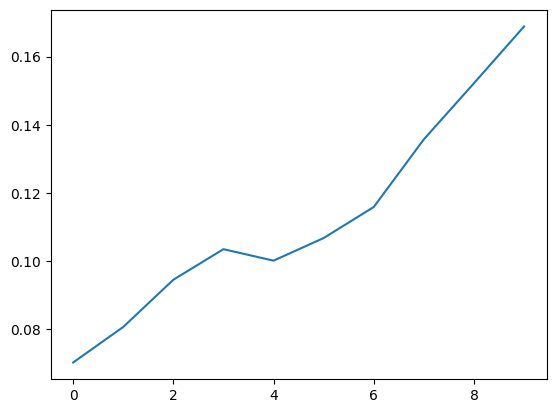

In [24]:
f_gan = []
for i in range(seq_len):
    y_gan = gen_test_y[:, i, 0]
    x_gan = gen_test_x[:, i, :]
    gan_test_data = torch.cat([tensor(gen_test_s), tensor(x_gan), tensor(y_gan).view(len(y_gan), 1)], dim=1)
    distance = compute_distance_loss(gan_test_data.to(device))
    f_gan.append(distance.item())

plt.plot(f_gan)

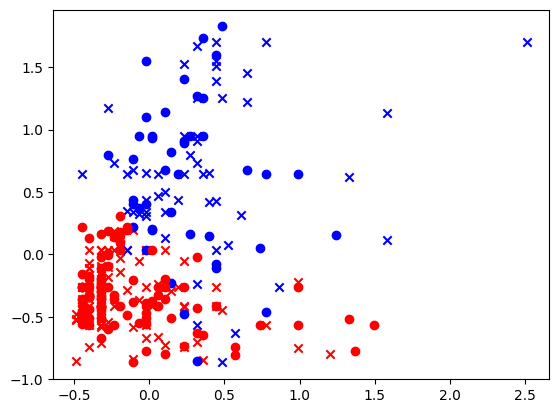

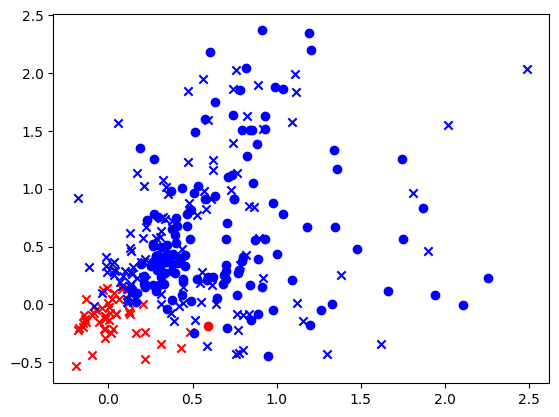

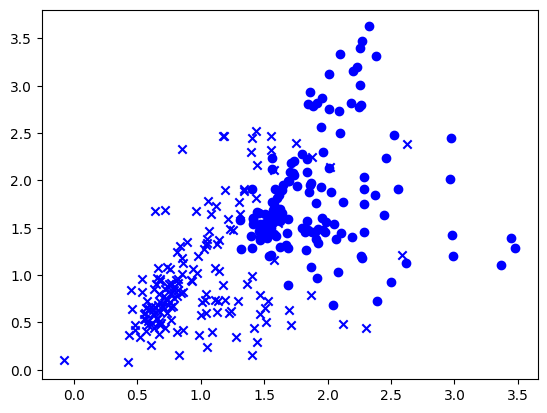

In [25]:
x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(300):
    if gen_train_y[i][0][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][0])
        z11.append(z_vars[i][0])
    elif gen_train_y[i][0][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][0])
        z01.append(z_vars[i][0])
    elif gen_train_y[i][0][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][0])
        z10.append(z_vars[i][0])
    else:
        x00.append(x_vars[i][0])
        z00.append(z_vars[i][0])

fig_start = plt.figure()
ax = fig_start.gca()

ax.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
ax.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
ax.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
ax.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(300):
    if gen_train_y[i][3][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][3])
        z11.append(z_vars[i][3])
    elif gen_train_y[i][3][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][3])
        z01.append(z_vars[i][3])
    elif gen_train_y[i][3][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][3])
        z10.append(z_vars[i][3])
    else:
        x00.append(x_vars[i][3])
        z00.append(z_vars[i][3])

fig_m = plt.figure()
axm = fig_m.gca()

axm.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axm.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axm.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axm.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

x01 = []
z01 = []
z00 = []
x00 = []
x10 = []
z10 = []
x11 = []
z11 = []

for i in range(300):
    if gen_train_y[i][9][0] == 1 and gen_train_s[i][0] == 1:
        x11.append(x_vars[i][9])
        z11.append(z_vars[i][9])
    elif gen_train_y[i][9][0] == 1 and gen_train_s[i][0] == 0:
        x01.append(x_vars[i][9])
        z01.append(z_vars[i][9])
    elif gen_train_y[i][9][0] == 0 and gen_train_s[i][0] == 1:
        x10.append(x_vars[i][9])
        z10.append(z_vars[i][9])
    else:
        x00.append(x_vars[i][9])
        z00.append(z_vars[i][9])

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x00, z00, marker = 'x', color = 'red', label='s=0, y=0')
axf.scatter(x11, z11, marker = 'o', color = 'blue', label='s=1, y=1')
axf.scatter(x01, z01, marker = 'x', color = 'blue', label='s=0, y=1')
axf.scatter(x10, z10, marker = 'o', color = 'red', label='s=1, y=0')

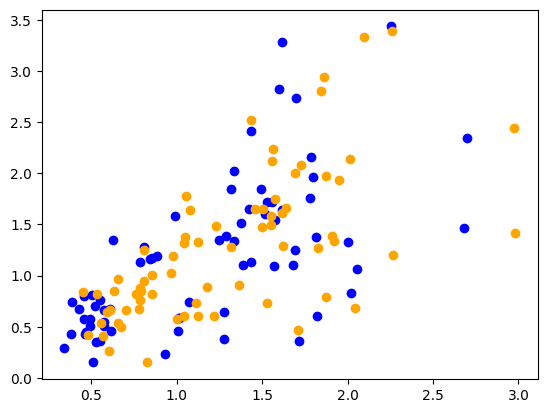

In [26]:
x_real_f = []
z_real_f = []

for i in range(70):
    x_real_f.append(x_train[i][9][0])
    z_real_f.append(x_train[i][9][1])

x_gan_f = []
z_gan_f = []
for i in range(70):
    x_gan_f.append(x_vars[i][9])
    z_gan_f.append(z_vars[i][9])

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x_real_f, z_real_f, color = 'blue')
axf.scatter(x_gan_f, z_gan_f, color = 'orange')

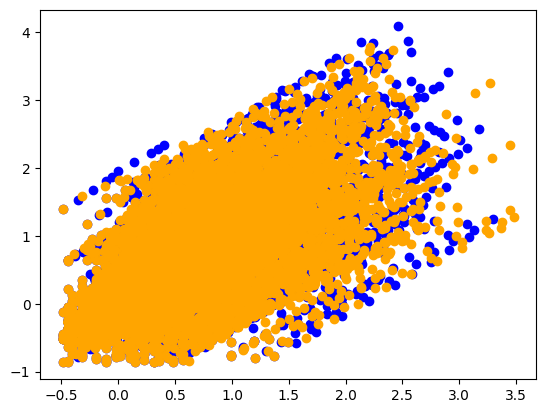

In [27]:
x_real_f = x_train[:, :, 0]
z_real_f = x_train[:, :, 1]

fig_f = plt.figure()
axf = fig_f.gca()

axf.scatter(x_real_f, z_real_f, color = 'blue')
axf.scatter(x_vars, z_vars, color = 'orange')

In [28]:
s = np.vstack([s_train, s_test, s_valid])
x = np.vstack([x_train, x_test, x_valid])
y = np.vstack([y_train, y_test, y_valid])

In [29]:
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [30]:
s = np.vstack([s_train, s_test, s_valid])
x = np.vstack([x_train, x_test, x_valid])
y = np.vstack([y_train, y_test, y_valid])
gan_output = np.empty((0, x_train.shape[2] + 2))

for i in range(seq_len):
    temp = np.hstack([s, x[:, i, :], y[:, i, :]])
    gan_output = np.vstack([gan_output, temp])

df = pd.DataFrame(gan_output)
df = df.set_axis(['SEX', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'Y'], axis=1)
df.to_csv('taiwan.csv')

In [31]:
pairs = np.empty((0, int(x_dim*2 + 3)))

for i in range(x.shape[0]):
    temp_pair = np.empty((1, int(x_dim*2 + 3)))
    temp_pair[0, 0] = s0[i]
    for j in range(x.shape[1] - 1):
        for k in range(x[0][0].shape[0]):
            temp_pair[0, 1+k] = x[i, j, k]
        temp_pair[0, 1+x_dim] = y[i, j][0]
        for k in range(x[0][0].shape[0]):
            temp_pair[0, 2 + x.shape[2] + k] = x[i, j+1, k]
        temp_pair[0, - 1] = y[i, j+1][0]
        pairs = np.vstack([pairs, temp_pair])
        
df = pd.DataFrame(pairs)
df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
df.to_csv('taiwan.csv')   
len(pairs)

9000

In [32]:
import os
from datasets.toy import ToySCM
from datasets.taiwan import TaiwanSCM
from models.vaca import VACA
import utils.args_parser  as argtools
from data_modules.het_scm import HeterogeneousSCMDataModule

scm = TaiwanSCM(None, 'train', len(pairs))
model_file = os.path.join('_params', 'model_vaca.yaml')
trainer_file = os.path.join('_params', 'trainer.yaml')

cfg = argtools.parse_args(model_file)
cfg.update(argtools.parse_args(trainer_file))

cfg['dataset'] = {
    'name': 'taiwan',
    'params1': {},
    'params2': {}
}

cfg['dataset']['params1']['batch_size'] = batch_size
cfg['dataset']['params1']['num_samples_tr'] = len(pairs)
cfg['dataset']['params1']['num_workers'] = 0
cfg['dataset']['params1']['equations_type'] = 'non-linear'
cfg['dataset']['params1']['normalize'] = 'lik'
cfg['dataset']['params1']['lambda_'] = 0.05
cfg['dataset']['params1']['data_dir'] = '../Data'
cfg['dataset']['params1']['device'] = device
cfg['dataset']['params1']['dataset_name'] = 'taiwan'

dataset_params = cfg['dataset']['params1']
data_module = HeterogeneousSCMDataModule(**dataset_params)

data_module.train_dataset._create_data()
data_module.valid_dataset._create_data()
data_module.test_dataset._create_data()
data_module.prepare_data()
data_module.train_dataloader()
data_module.test_dataloader()
data_module.val_dataloader()


cfg['model']['params']['is_heterogeneous'] = scm.is_heterogeneous
cfg['model']['params']['likelihood_x'] = scm.likelihood_list

cfg['model']['params']['num_nodes'] = scm.num_nodes
cfg['model']['params']['edge_dim'] = scm.edge_dimension

model_params = cfg['model']['params']

model_vaca = VACA(**model_params)
model_vaca.set_random_train_sampler(data_module.get_random_train_sampler())

model_vaca.set_optim_params(optim_params=cfg['optimizer'],
                            sched_params=cfg['scheduler'])

In [33]:
data_module.train_dataset

In [34]:
from models._evaluator import MyEvaluator

evaluator = MyEvaluator(model=model_vaca,
                        intervention_list=data_module.train_dataset.get_intervention_list(),
                        scaler=data_module.scaler
                        )
model_vaca.set_my_evaluator(evaluator=evaluator)

assert evaluator is not None
is_training = train_vaca
del cfg['trainer']['progress_bar_refresh_rate']
del cfg['trainer']['flush_logs_every_n_steps']
del cfg['trainer']['terminate_on_nan']
del cfg['trainer']['auto_select_gpus']
del cfg['trainer']['weights_summary']
cfg['trainer']['enable_model_summary'] = False
del cfg['trainer']['gpus']
del cfg['trainer']['track_grad_norm']


In [35]:
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import pytorch_lightning as pl

yaml_file = ''
if yaml_file == '':
        save_dir = argtools.mkdir(os.path.join(cfg['root_dir'],
                                               argtools.get_experiment_folder(cfg),
                                               str(cfg['seed'])))
else:
        save_dir = os.path.join(yaml_file.split('/')[:-1])
print(f'Save dir: {save_dir}')
# trainer = pl.Trainer(**cfg['model'])
logger = TensorBoardLogger(save_dir=save_dir, name='logs', default_hp_metric=False)
out = logger.log_hyperparams(argtools.flatten_cfg(cfg))

save_dir_ckpt = argtools.mkdir(os.path.join(save_dir, 'ckpt'))
ckpt_file = argtools.newest(save_dir_ckpt)
callbacks = []
if is_training == 1:
    
    checkpoint = ModelCheckpoint(monitor=model_vaca.monitor(),
                                     mode=model_vaca.monitor_mode(),
                                     save_top_k=1,
                                     save_last=True,
                                     filename='checkpoint-{epoch:02d}',
                                     dirpath=save_dir_ckpt)

    callbacks = [checkpoint]

    if cfg['early_stopping']:
            early_stopping = EarlyStopping(model_vaca.monitor(), mode=model_vaca.monitor_mode(), min_delta=0.0,
                                           patience=50)
            callbacks.append(early_stopping)

    if ckpt_file is not None:
            print(f'Loading model training: {ckpt_file}')
            trainer = pl.Trainer(logger=logger, callbacks=callbacks, **cfg['trainer'], devices='auto', accelerator='cpu')
    else:

            trainer = pl.Trainer(logger=logger, callbacks=callbacks, **cfg['trainer'], devices='auto', accelerator='cpu')

    trainer.fit(model=model_vaca, datamodule=data_module)
    trainer.validate(ckpt_path=ckpt_file, dataloaders=data_module.val_dataloader())
    trainer.test(ckpt_path=ckpt_file, dataloaders=data_module.test_dataloader())
    argtools.save_yaml(cfg, file_path=os.path.join(save_dir, 'hparams_full.yaml'))
    
else:
        model_vaca = VACA.load_from_checkpoint(ckpt_file, **model_params)

Save dir: exper_test_10pct_noise/taiwan_/vaca/dgnn_elbo_8_8_16_4_normal_0.0_0.2_0.0_0.0_0_True_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[NormalLikelihood()]_[BernoulliLikelihood()]_9_31/adam/0.005_0.9_0.999_1.2e-06_exp_lr_0.99/9


In [36]:

evaluator.set_model(model_vaca)
model_vaca.set_my_evaluator(evaluator=evaluator)


In [37]:
model_parameters = filter(lambda p: p.requires_grad, model_vaca.parameters())
params = int(sum([np.prod(p.size()) for p in model_parameters]))
model_vaca.eval()
model_vaca.freeze()

In [38]:
def p_to_csv(s, x, y, dataset):
    if isinstance(s, torch.Tensor):
        s = s.cpu().detach().numpy()
    if isinstance(x, torch.Tensor):
        x = x.cpu().detach().numpy()
    if isinstance(y, torch.Tensor):
        y = y.cpu().detach().numpy()
    
    if dataset == 'toy':
        pairs = np.empty((0, 7))
        for i in range(x.shape[0]):
            temp = np.empty((1, x.shape[2]*2 + 3))
            temp[0, 0] = s[i]
            for j in range(x.shape[1] - 1):
                for k in range(x.shape[2]):
                    temp[0, 1+k] = x[i, j, k]
                temp[0, 1+x.shape[2]] = y[i, j][0]
                for k in range(x.shape[2]):
                    temp[0, 2 + x.shape[2] + k] = x[i, j+1, k]
                temp[0, -1] = y[i, j+1][0]
            pairs = np.vstack([pairs, temp])
        df = pd.DataFrame(pairs)
        df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
        df.to_csv('steps.csv')
        return pairs
    elif dataset == 'taiwan':
        pairs = np.empty((0, 9))
        for i in range(x.shape[0]):
            temp = np.empty((1, x.shape[2]*2 + 3))
            temp[0, 0] = s[i]
            for j in range(x.shape[1] - 1):
                for k in range(x.shape[2]):
                    temp[0, 1+k] = x[i, j, k]
                temp[0, 1+x.shape[2]] = y[i, j][0]
                for k in range(x.shape[2]):
                    temp[0, 2 + x.shape[2] + k] = x[i, j+1, k]
                temp[0, -1] = y[i, j+1][0]
            pairs = np.vstack([pairs, temp])

        df = pd.DataFrame(pairs)
        df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
        df.to_csv('taiwan.csv')    
        return pairs   

In [39]:
def vaca_dataset(batch_size, pairs, device, dataset):
    model_file = os.path.join('_params', 'model_vaca.yaml')

    cfg = argtools.parse_args(model_file)    
    cfg['dataset'] = {
        'name': dataset,
        'params1': {},
        'params2': {}
    }

    cfg['dataset']['params1']['batch_size'] = batch_size
    cfg['dataset']['params1']['num_samples_tr'] = len(pairs)
    cfg['dataset']['params1']['num_workers'] = 0
    cfg['dataset']['params1']['equations_type'] = 'non-linear'
    cfg['dataset']['params1']['normalize'] = 'lik'
    cfg['dataset']['params1']['lambda_'] = 0.05
    cfg['dataset']['params1']['data_dir'] = '../Data'
    cfg['dataset']['params1']['device'] = device
    cfg['dataset']['params1']['dataset_name'] = dataset

    dataset_params = cfg['dataset']['params1']
    data_module = HeterogeneousSCMDataModule(**dataset_params)

    data_module.train_dataset._create_data()
    data_module.valid_dataset._create_data()
    data_module.test_dataset._create_data()
    data_module.total_dataset._create_data()
    data_module.prepare_data()
    data_module.train_dataloader()
    data_module.test_dataloader()
    data_module.val_dataloader()
    data_module.total_dataloader()
    return data_module

In [40]:

def intervention(nodes, values):
    inter = {}
    for i in range(len(nodes)):
        inter[nodes[i]] = values[i].item()
    return inter

def logistic(x):
    return torch.log(1 + torch.exp(x))


In [41]:
class Generator2(nn.Module):

    def __init__(self, in_size, hidden_size, num_layers):
        super().__init__()

        self.num_layers = num_layers
        self.h0_linear = nn.Linear(in_size, hidden_size)
        self.rnn = nn.GRU(in_size + 3, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, in_size)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x0, noise, s0, clf):
        ss = torch.clone(s0)
        ss = ss.to(x0.device)
        s0 = torch.zeros(s0.size(0), 2).to(x0.device).scatter_(1, s0.long(), torch.ones_like(s0, device=x0.device))
        s0 = s0.to(x0.device)

        h0 = self.h0_linear(x0)
        h0 = h0.unsqueeze(0).repeat(self.num_layers, 1, 1)
        yt = clf(ss, x0)
        
        xs, ys = [x0], [yt]
        for i in range(noise.size(1)):
            
            y_noise = torch.cat([s0, yt, noise[:, i]], dim=-1).unsqueeze(1)
            output, h0 = self.rnn(y_noise, h0)
            # xt = self.sigmoid(self.linear(output).squeeze())
            xt = self.linear(output).squeeze()
            yt = clf(ss, xt)

            xs.append(xt)
            ys.append(yt)

        xs = torch.stack(xs, dim=1)
        ys = torch.stack(ys, dim=1)
        return xs, ys, ys.round()
    

In [42]:
generator = Generator2(x_dim, g_hidden_size, g_num_layers)
generator.to(device)
generator.load_state_dict(torch.load(gan_path, map_location=device))

<All keys matched successfully>

In [43]:
def intervention_step(loader, vaca, intervention_nodes, e, nodes):
    k = 0
    x_gan_input_list = []

    for batch in loader:

            batch.x_i = batch.x + e[k].to(batch.x.device).view(batch.x.shape)
            
        
            z_f, _ = vaca.model.encoder(batch.x, batch.edge_index, edge_attr=batch.edge_attr, return_mean=True, node_ids=batch.node_ids)
            z_cf_I, _ = vaca.model.encoder(batch.x_i, batch.edge_index_i, edge_attr=batch.edge_attr_i,return_mean=True, node_ids=batch.node_ids)

            z_factual = z_f.reshape(1, -1)
            z_cf_I = z_cf_I.reshape(1, -1)

            z_dec = z_factual
            z_dim = vaca.z_dim

            for node_name in intervention_nodes:
                node_idx = loader.dataset.nodes_list.index(node_name)
                z_dec[:, z_dim * node_idx:z_dim * (node_idx + 1)] = z_cf_I[:, z_dim * node_idx: z_dim * (node_idx + 1)]

            z_dec = z_dec.reshape(-1, z_dim)

            x_CF, px_z = vaca.model.decoder(z_dec, batch.edge_index_i, edge_attr=batch.edge_attr_i, return_type='mean',  node_ids=batch.node_ids)
            adj = []
            for i in range(max(x_CF.shape)):
                if type(px_z.distributions[i]) == torch.distributions.normal.Normal:
                    adj.append(px_z.distributions[i].stddev)
                else:
                    adj.append(torch.tensor(0))

            x_CF+=(torch.tensor(adj)*torch.randn_like(x_CF))

            # x_CF = x_CF.view(len(nodes), -1)

            x_gan_input_list.append(x_CF[:,-int((len(nodes))/2):-1].clone())

            k+=1
            if k == len(loader):
                break

    x_gan_input = torch.stack(x_gan_input_list, dim=0)


    return x_gan_input

In [44]:
def intervene(datamodule, loader, vaca, generator, clf, efforts, seq_len, dataset, device):
    nodes = datamodule.train_dataset.nodes_list
    intervention_nodes = datamodule.train_dataset.nodes_to_intervene
    # _inter = intervention(intervention_nodes, efforts[0])
    s = tensor(loader.dataset.X[:,0]).view(len(loader.dataset), 1).to(device)
    x_gan_input = torch.empty(len(loader), int((len(nodes)-2)))
    y_pred = torch.empty(len(loader), 0).to(device)
    y_pred.requires_grad_(True)
    datamodule.batch_size = 1
    x_post_int = torch.empty(len(loader), seq_len, int(len(nodes)/2-1)).to(device)
    x_post_int[:, 0, :] = tensor(loader.dataset.X[:, 1:int(len(nodes)/2)]).clone().to(device)
    inter_index = []
    for n in range(len(nodes)):
        if nodes[n] in intervention_nodes:
            inter_index.append(n)

    t = torch.empty(len(loader), 0)
    for ns in inter_index:
        t = torch.cat([t, torch.ones((len(loader),1))*ns], dim=1)

    t = t.type(torch.int64)

    t = t.to(device)
    efforts = efforts.to(device)
    
    for i in range(0, seq_len-1):
        
        e = torch.zeros((len(loader), len(nodes))).to(device).scatter(1, t, efforts.view(len(loader), seq_len-1, len(intervention_nodes))[:, i, :]).to(device)

        datamodule.batch_size = 1

        x_gan_input = intervention_step(loader, vaca, intervention_nodes, e, nodes)

        z_mb = torch.randn(len(loader), 1, int((len(nodes)/2-1)))

        gen_x_mb, _, gen_y_mb = generator(x_gan_input.view(len(loader), int((len(nodes)/2-1))).to(device), z_mb.to(device), s.reshape(len(loader),1).to(device), clf.to(device))
        y_pred = torch.cat([y_pred, gen_y_mb[:,0].to(device)], 1)
        
        x_next_steps = gen_x_mb[:, -2:, :]
        y_next_steps = gen_y_mb[:, -2:, :]
        x_post_int[:, i, :] = gen_x_mb[:, 0, :].clone()

        data = torch.cat([s.to(device), x_post_int[:, i, :].to(device), gen_y_mb[:,0].to(device)], 1)
        
        p_to_csv(s, x_next_steps, y_next_steps, dataset)

        datamodule = vaca_dataset(1, y_next_steps, device, dataset)
        loader = datamodule.total_dataloader()
        loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
        loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
    
    x_post_int[:, 0, :] = tensor(loader.dataset.X[:, 1:int(len(nodes)/2)]).clone().to(device)

    return y_pred, x_post_int, data
        


In [45]:
class effortNN(nn.Module):
    def __init__(self, datamodule, loader, seq_len, device):
        super(effortNN, self).__init__()
        self.fc1 = nn.Linear(int(datamodule.num_nodes), 128, bias=True, device=device)
        self.ln1 = nn.LayerNorm(128)
        self.fc2 = nn.Linear(128, 64, bias=True, device=device)
        self.ln2 = nn.LayerNorm(64)
        self.fc3 = nn.Linear(64, int(len(datamodule.train_dataset.nodes_to_intervene) * int(seq_len-1)), device=device)
        layers = []
        layers.append(self.fc1)
        layers.append(self.ln1)
        layers.append(nn.ReLU())
        layers.append(self.fc2)
        layers.append(self.ln2)
        layers.append(nn.ReLU())
        layers.append(self.fc3)

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        efforts = self.fc3(x)

        return efforts
    

def budget_penalty(efforts, total_budget):
    b_loss = 0
    for i in range(efforts.shape[0]):
        b_loss += torch.relu(torch.sum(torch.abs(efforts[i])) - total_budget)
    return b_loss

def total_loss(efforts, total_budget, improvement_loss):
    budget_loss = budget_penalty(efforts, total_budget)
    t_loss = 100000*budget_loss + improvement_loss
    return t_loss

In [46]:
def compute_st_loss(s, y_pred):
    st_loss = 0.0
    for i in range(y_pred.shape[1]):
        y_neg = y_pred[s.squeeze() == 0, i]
        y_pos = y_pred[s.squeeze() == 1, i]
        p_y_pos = torch.sum(y_pos >= 0.5) / len(y_pos)
        p_y_neg = torch.sum(y_neg >= 0.5) / len(y_neg)
        st_loss += torch.abs(p_y_pos - p_y_neg)

    return st_loss/y_pred.shape[1]

def compute_post_long_cond_probs(s, Xs, Ys, clf):
    probs = {}
    
    for i in range(len(Xs)-1):
        
        XXs_comb = np.c_[s[s == 1], Xs[i][s == 1], Xs[i+1][s == 1]]
        Xs_comb = np.c_[s[s == 1], Xs[i][s == 1]]
        lr_up = LogisticRegression(random_state=2021).fit(XXs_comb, Ys[i][s == 1])
        lr_dn = LogisticRegression(random_state=2021).fit(Xs_comb, Ys[i][s == 1])
        probs_up = lr_up.predict_proba(XXs_comb)
        probs_dn = lr_dn.predict_proba(Xs_comb)
        probs[f'pos(y{i+1}=0)'] = probs_up[:, 0] / probs_dn[:, 0]
        probs[f'pos(y{i+1}=1)'] = probs_up[:, 1] / probs_dn[:, 1]


        XXs_comb = np.c_[s[s == 0], Xs[i][s == 0], Xs[i+1][s == 0]]
        Xs_comb = np.c_[s[s == 0], Xs[i][s == 0]]
        lr_up = LogisticRegression(random_state=2021).fit(XXs_comb, Ys[i][s == 0])
        lr_dn = LogisticRegression(random_state=2021).fit(Xs_comb, Ys[i][s == 0])
        probs_up = lr_up.predict_proba(XXs_comb)
        probs_dn = lr_dn.predict_proba(Xs_comb)
        probs[f'neg(y{i+1}=0)'] = probs_up[:, 0] / probs_dn[:, 0]
        probs[f'neg(y{i+1}=1)'] = probs_up[:, 1] / probs_dn[:, 1]
    return probs

def compute_lt_loss(s, y_pred, y0):

    y_neg = y_pred[(s.squeeze() == 0) & (y0.squeeze() == 0), -1]
    y_pos = y_pred[(s.squeeze() == 1) & (y0.squeeze() == 0), -1]
    p_y_neg = torch.sum(y_neg >= 0.5) / len(y_neg)
    p_y_pos = torch.sum(y_pos >= 0.5) / len(y_pos)
    lt_loss = torch.abs(p_y_pos - p_y_neg)
    
    return lt_loss

In [47]:
p_to_csv(s, x[:, 0:2, :], y[:, 0:2, :], 'taiwan')
data_module = vaca_dataset(batch_size, s, device, dataset='taiwan')
original_pairs = data_module.total_dataloader().dataset.X

In [48]:
class TemporalAttention(nn.Module):
    def __init__(self, hidden_size):
        super(TemporalAttention, self).__init__()
        self.attention_weights = nn.Linear(hidden_size, 1)

    def forward(self, lstm_out):
        """
        Args:
            lstm_out: Tensor of shape (batch_size, seq_len, hidden_size)
        Returns:
            context: Tensor of shape (batch_size, hidden_size), the weighted sum of LSTM outputs
            attention_scores: Tensor of shape (batch_size, seq_len), attention weights for each timestep
        """
        # Compute attention scores
        scores = self.attention_weights(lstm_out).squeeze(-1)  # Shape: (batch_size, seq_len)
        scores = torch.softmax(scores, dim=1)  # Normalize scores across timesteps

        # Compute context vector as weighted sum of LSTM outputs
        context = torch.sum(lstm_out * scores.unsqueeze(-1), dim=1)  # Shape: (batch_size, hidden_size)

        return context, scores

In [49]:
class effortLSTM(nn.Module):
    def __init__(self, datamodule, loader, seq_len, device):
        super(effortLSTM, self).__init__()

        self.seq_len = seq_len
        self.num_interventions = len(datamodule.train_dataset.nodes_to_intervene)
        self.hidden_size = 128

        self.lstm = nn.LSTM(int((datamodule.num_nodes) + self.num_interventions), self.hidden_size, num_layers=2, batch_first=True)
        self.attention = TemporalAttention(self.hidden_size)
        self.init_interventions = nn.Parameter(torch.zeros(1, self.num_interventions))
        
        self.fc = nn.Linear(self.hidden_size, self.num_interventions)

        self.to(device)

    def forward(self, x):

        batch_size = x.size(0)

        h_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)
        c_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)

        efforts_seq = []
        efforts = self.init_interventions.repeat(batch_size, 1)

        all_hidden_states = []
        x_squeezed = x.squeeze(1)
        
        for _ in range(seq_len-1):
            x_combined = torch.cat([x_squeezed, efforts], dim=-1)
            lstm_out, (h_0, c_0) = self.lstm(x_combined.unsqueeze(1), (h_0, c_0))
            all_hidden_states.append(lstm_out.squeeze(1))

            hidden_tensor = torch.stack(all_hidden_states, dim=1)
            context, attention_scores = self.attention(hidden_tensor)

            efforts = self.fc(context)
            efforts_seq.append(efforts)

        efforts_seq = torch.stack(efforts_seq, dim=1)

        return efforts_seq
    
class effortLSTM_clf(nn.Module):
    def __init__(self, datamodule, seq_len, clf, device):
        super(effortLSTM_clf, self).__init__()

        self.seq_len = seq_len
        self.num_interventions = len(datamodule.train_dataset.nodes_to_intervene)
        self.hidden_size = 128
        self.clf = clf

        for param in self.clf.parameters():
            param.requires_grad = False

        self.lstm = nn.LSTM(int((datamodule.num_nodes) + self.num_interventions), self.hidden_size, num_layers=2, batch_first=True)
        self.attention = TemporalAttention(self.hidden_size)

        self.fc = nn.Linear(self.hidden_size, self.num_interventions)
        self.init_interventions = nn.Parameter(torch.zeros(1, self.num_interventions))

        self.to(device)

    def forward(self, x):

        s0 = x[:, 0, 0].view(x.size(0), 1)

        batch_size = x.size(0)
        
        clf_outputs = self.clf(s0, x[:, 0, -4:-1])
        
        x_with_y = torch.cat([x[:,0,:-1], clf_outputs.view(batch_size,1)], dim=1)
        h_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)
        c_0 = torch.zeros(2, batch_size, self.hidden_size).to(x.device)

        efforts = self.init_interventions.repeat(batch_size, 1)

        all_hidden_states = []

        efforts_seq = []
        
        for _ in range(seq_len-1):
            clf_outputs = self.clf(s0, x[:, 0, -4:-1])
            x_with_y = torch.cat([x[:,0,:-1], clf_outputs.view(batch_size,1), efforts], dim=1).unsqueeze(1)
            lstm_out, (h_0, c_0) = self.lstm(x_with_y, (h_0, c_0))

            all_hidden_states.append(lstm_out.squeeze(1))
            hidden_tensor = torch.stack(all_hidden_states, dim=1)
            context, attention_scores = self.attention(hidden_tensor)

            efforts = self.fc(context)
            efforts_seq.append(efforts)

        efforts_seq = torch.stack(efforts_seq, dim=1)

        return efforts_seq

In [50]:
def save_checkpoint(epoch, model, optimizer, best_loss, filepath):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_loss': best_loss
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at epoch {epoch}")

def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_loss = checkpoint['best_loss']
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded - Resuming from epoch {epoch}, Best Loss: {best_loss}")
    return epoch, best_loss

In [51]:
import yaml

def load_config(config_path="weights.yaml"):
    """Loads the YAML configuration file."""
    with open(config_path, "r") as file:
        return yaml.safe_load(file)

def get_loss_weights(model, dataset, budget, config):
    """Retrieves the correct loss weights based on model, budget, and dataset."""
    try:
        return config["weights"][model][dataset][budget]
    except KeyError:
        raise ValueError(f"Invalid combination: model={model}, dataset={dataset}, budget={budget}")

# Example Usage
config = load_config()


## Training

In [53]:
df = pd.DataFrame(t0)
df = df.set_axis(['SEX', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'Y'], axis=1)
df.to_csv('taiwan.csv')
data_module = vaca_dataset(1, t0, device, 'taiwan')
original_pairs = data_module.total_dataloader().dataset.X

NameError: name 't0' is not defined

In [ ]:
loader = data_module.test_dataloader()
loader.dataset.set_intervention({'LIMIT_BAL': 0}, is_noise=True)
data_module.batch_size = 1
loss_fn = torch.nn.MSELoss(reduction='mean')
net = effortNN(data_module, loader, seq_len, device)
budget = 2*seq_len
dataset = 'taiwan'
efforts_path = log_dir / (f"effort_model" + dataset + "_budget_" + str(budget) + ".pth")
net.load_state_dict(torch.load(efforts_path, map_location=device))
original_data = data_module.total_dataloader().dataset.X
s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

efforts = net(tensor(loader.dataset.X).to(device))
y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, dataset, device)
improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
st_fairness = compute_st_loss(s, y_hat)
lt_fairness = compute_distance_loss(data)
t_loss = 10000*budget_penalty(efforts, budget) + 0.1*improvement_loss + lt_fairness

df = pd.DataFrame(t0)
df = df.set_axis(['SEX', 'LIMIT_BAL', 'PAY_AMT1', 'PAY_AMT2', 'Y'], axis=1)
df.to_csv('taiwan.csv')
print(f'Total Loss: {t_loss: 8.2f} | Improvement Loss: {improvement_loss: 3.4} | Budget Loss: {10000*budget_penalty(efforts, budget) : 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Long Fairness Loss: {lt_fairness: 3.4f}')


Total Loss:     0.13 | Improvement Loss:  0.6066 | Budget Loss:  0.0000 | Short Fairness Loss:  0.0809 | Long Fairness Loss:  0.0667


: 

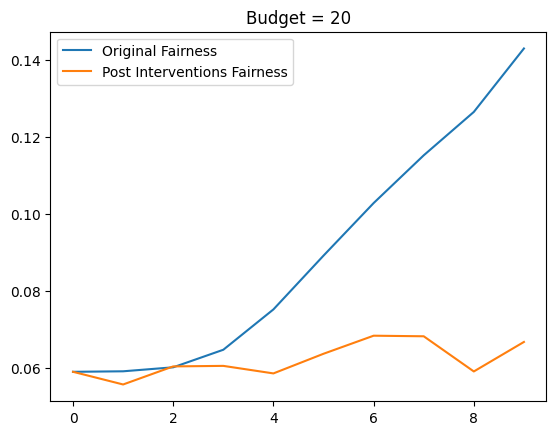

: 

In [ ]:
timeline = range(seq_len)
data_t = torch.empty(len(loader), 1, x_dim + 2)
f_model = []
for i in range(seq_len):
    data_t = torch.cat([s.view(len(loader), 1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
    distance = compute_distance_loss(data_t)
    f_model.append(distance.item())
f_model[0] = f_gan[0]
plt.plot(timeline, f_gan, label='Original Fairness')
plt.plot(timeline, f_model, label='Post Interventions Fairness')
plt.title(f'Budget = 20')
plt.legend()
plt.savefig(f'Fairness plot Budget = 20.png')
plt.show()


In [ ]:
loss_weights = get_loss_weights('LSTM', 'taiwan', 10, config)
loss_weights = [x/sum(loss_weights) for x in loss_weights]
imp_w, lt_w, st_w = loss_weights

(0.009803921568627453, 0.9803921568627452, 0.009803921568627453)

Epoch:    0 | Total Loss:   0.0782 | Budget Loss:  0.00 | Long Fairness Loss:  0.0725 | Improvement Loss:  0.6449 | Time:  190.4 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 2
Checkpoint saved at epoch 3
Checkpoint saved at epoch 4
Checkpoint saved at epoch 8
Epoch:   10 | Total Loss:   0.0958 | Budget Loss:  0.00 | Long Fairness Loss:  0.0911 | Improvement Loss:  0.5538 | Time:  187.4 | Patience: 2
Early stopping
 Last save: 8
Last saved epoch:  8


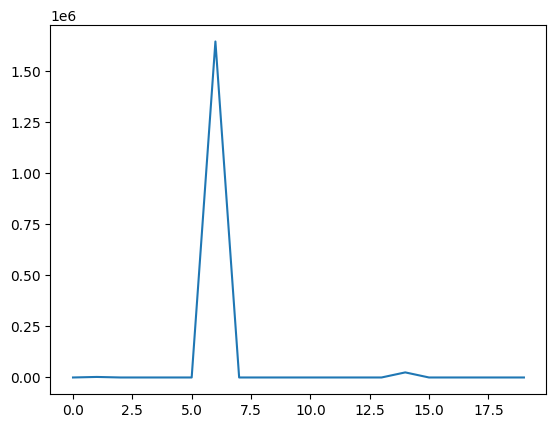

Epoch:    0 | Total Loss:   0.0884 | Budget Loss:  0.00 | Long Fairness Loss:  0.0843 | Improvement Loss:  0.6624 | Time:  190.4 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 7
Epoch:   10 | Total Loss:   0.0947 | Budget Loss:  0.00 | Long Fairness Loss:  0.0895 | Improvement Loss:  0.6611 | Time:  188.9 | Patience: 3
Early stopping
 Last save: 7
Last saved epoch:  7


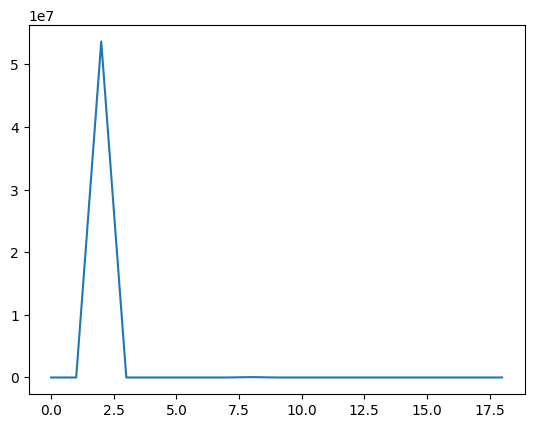

Epoch:    0 | Total Loss:   0.0872 | Budget Loss:  0.00 | Long Fairness Loss:  0.0833 | Improvement Loss:  0.6157 | Time:  196.4 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 3
Checkpoint saved at epoch 4
Checkpoint saved at epoch 6
Checkpoint saved at epoch 7
Epoch:   10 | Total Loss:   0.0426 | Budget Loss:  0.00 | Long Fairness Loss:  0.0388 | Improvement Loss:  0.8433 | Time:  188.1 | Patience: 3
Early stopping
 Last save: 7
Last saved epoch:  7


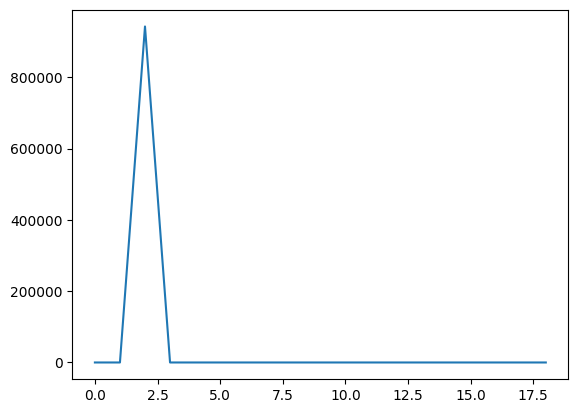

In [ ]:
import time
t0 = original_pairs
df = pd.DataFrame(t0)
df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
df.to_csv('taiwan.csv')   
data_module = vaca_dataset(1, t0, device, 'taiwan')
loader = data_module.train_dataloader()
data_module.batch_size = 1
loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
loader = data_module.train_dataloader()
loss_fn = torch.nn.MSELoss()
net = effortLSTM(data_module, loader, seq_len, device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

b_list = [1, 2, 3, 4]
config = load_config()
for b in b_list:
    budget = b*seq_len
    df = pd.DataFrame(t0)
    df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
    df.to_csv('taiwan.csv')   
    loss_weights = get_loss_weights('LSTM', 'taiwan', budget, config)
    loss_weights = [x/sum(loss_weights) for x in loss_weights]
    imp_w, lt_w, st_w = loss_weights
    data_module = vaca_dataset(1, t0, device, 'taiwan')
    loader = data_module.train_dataloader()
    data_module.batch_size = 1
    loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
    loss_fn = torch.nn.MSELoss()
    net = effortLSTM(data_module, loader, seq_len, device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    efforts_path = log_dir / (f"LSTM_effort_model" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + ".pth")
    checkpoint_path = log_dir / (f"LSTM_effort_model" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_checkpoint.pth")
    best_loss = float('inf')
    patience = 0
    last_epoch=0
   

    hist_loss = []
    for epoch in range(last_epoch, 100):
        epoch_start = time.time()
        net.train()
        efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
        optimizer.zero_grad()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts.view(len(loader), seq_len-1, 2), seq_len, dataset ,device)
        improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
        lt_fairness = compute_distance_loss(data)
        st_fairness = compute_st_loss(s, y_hat)
        t_loss = 10000*budget_penalty(efforts, budget*0.95) + imp_w*improvement_loss + lt_w*lt_fairness + st_w*st_fairness
        
        t_loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        optimizer.step()

        net.eval()
        with torch.no_grad():
            val_loss = 0.0
            df = pd.DataFrame(t0)
            df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
            df.to_csv('taiwan.csv')   
            data_module = vaca_dataset(1, t0, device, 'taiwan')
            val_loader = data_module.val_dataloader()
            data_module.batch_size = 1
            val_s = tensor(val_loader.dataset.X[:,0]).view(len(val_loader.dataset), 1).to(device)
            val_loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
            val_efforts = net(tensor(val_loader.dataset.X).view(len(val_loader.dataset), 1, int(x_dim*2)+3).to(device))
            val_y, val_x, val_data = intervene(data_module, val_loader, model_vaca, generator, clf, val_efforts, seq_len, 'taiwan', device)
            val_loss = 10000*budget_penalty(val_efforts, budget*0.95) + imp_w*loss_fn(val_y, torch.ones_like(val_y)) + lt_w*compute_distance_loss(val_data) + st_w*compute_st_loss(val_s, val_y)

        scheduler.step(val_loss)

        df = pd.DataFrame(t0)
        df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
        df.to_csv('taiwan.csv')   
        epoch_end = time.time()
        hist_loss.append(t_loss.item())
        if (t_loss < best_loss and epoch > 0):
            best_loss = t_loss
            patience = 0
            torch.save(net.state_dict(), efforts_path)
            save_checkpoint(epoch, net, optimizer, best_loss, checkpoint_path)
            e = epoch
            
        
        else:
            patience += 1
            if (patience > 10 and 10000*budget_penalty(efforts, budget*.95) < 0.01):
                print('Early stopping')
                print(f' Last save: {e}')
                break

        if epoch % 10 == 0:
            print(f'Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}')

    print('Last saved epoch: ', e)

    plt.plot(np.arange(0, len(hist_loss), 1), hist_loss)
    plt.show()


In [ ]:
import time

# Define grid search hyperparameters
imp_w = torch.tensor(0.05, requires_grad = True, device = device)
lt_w = torch.tensor(1.0, requires_grad = True, device = device)
st_w = torch.tensor(0.01, requires_grad = True, device = device)

mu_t = torch.tensor(10.0, requires_grad = True, device = device)
tau = 0.05
budget = 1*seq_len

lambda_optimizer = torch.optim.Adam([imp_w, lt_w, st_w], lr=0.01)
mu_optimizer = torch.optim.Adam([mu_t], lr=0.01)

best_loss = float('inf')
best_params = None

# Iterate through all combinations
for outer_iter in range(50):
        
    print(f"Outer Iteration {outer_iter+1}: Learning Hyperparameters")

    t0 = original_pairs
    df = pd.DataFrame(t0)
    df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
    df.to_csv('taiwan.csv')   
    data_module = vaca_dataset(1, t0, device, 'taiwan')
    loader = data_module.train_dataloader()
    data_module.batch_size = 1
    loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
    loader = data_module.train_dataloader()
    loss_fn = torch.nn.MSELoss()
    net = effortLSTM_clf(data_module, seq_len, clf, device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

    s = tensor(loader.dataset.X[:,0]).to(device)
    y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    hist_loss = []
    patience = 0
    for epoch in range(50):
            epoch_start = time.time()
            t_weight = imp_w + lt_w + st_w
            net.train()
            efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
            optimizer.zero_grad()

            y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, 
                                        efforts.view(len(loader), seq_len-1, 2), seq_len, dataset, device)

            # Compute losses
            improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
            lt_fairness = compute_distance_loss(data)
            st_fairness = compute_st_loss(s, y_hat)

            # Compute weighted total loss
            t_loss = (10000 * budget_penalty(efforts, budget*0.95) + 
                    imp_w/t_weight * improvement_loss + 
                    lt_w/t_weight * lt_fairness + 
                    st_w/t_weight * st_fairness + 
                    mu_t * torch.relu(compute_st_loss(s, y_hat[:, -1].unsqueeze(1)) - tau))

            t_loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer.step()

            hist_loss.append(t_loss.item())

            # Validation loss
            net.eval()
            with torch.no_grad():
                val_loader = data_module.val_dataloader()
                val_s = tensor(val_loader.dataset.X[:,0]).to(device)
                val_loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
                val_efforts = net(tensor(val_loader.dataset.X).view(len(val_loader.dataset), 1, int(x_dim*2)+3).to(device))
                val_y, val_x, val_data = intervene(data_module, val_loader, model_vaca, generator, clf, val_efforts, seq_len, 'taiwan', device)
                val_loss = (10000 * budget_penalty(val_efforts, budget*0.95) + 
                            imp_w/t_weight * loss_fn(val_y, torch.ones_like(val_y)) + 
                            lt_w/t_weight * compute_distance_loss(val_data) + 
                            st_w/t_weight * compute_st_loss(val_s, val_y) + 
                            mu_t * torch.relu(compute_st_loss(val_s, val_y[:, -1].unsqueeze(1)) - tau))

            scheduler.step(val_loss)

            epoch_end = time.time()

            if val_loss.item() < best_loss:
                print(f'Best loss: {best_loss:.4f} | Val loss: {val_loss:.4f}')
                best_loss = val_loss.item()
                patience = 0
                best_params = (imp_w, lt_w, st_w)
                print(f"Best Parameters: Improvement Weight = {imp_w}, LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}, Best Loss = {best_loss:.4f}")

            else:
                patience += 1
                if (patience > 10 and epoch > 0):
                    print('Early stopping')
                    break

            if epoch % 10 == 0:
                print(f"Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*0.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Short Fairness Loss : {st_fairness: 3.2f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}")
            
    mu_optimizer.zero_grad()
    penalty_term = torch.relu(st_fairness - tau)
    (-mu_t * penalty_term).backward()
    mu_optimizer.step()
    mu_t.data = torch.clamp(mu_t, min = 0)

    lambda_optimizer.step()
    
print(f"Best Parameters: Improvement Weight = {best_params[0]}, LT Fairness Weight = {best_params[1]}, ST Fairness Weight = {best_params[2]}, Best Loss = {best_loss:.4f}")

Outer Iteration 1: Learning Hyperparameters
Best loss: inf | Val loss: 0.8405
Best Parameters: Improvement Weight = 0.05000000074505806, LT Fairness Weight = 1.0, ST Fairness Weight = 0.009999999776482582, Best Loss = 0.8405
Epoch:    0 | Total Loss:   1.9808 | Budget Loss:  0.00 | Long Fairness Loss:  0.0932 | Improvement Loss:  0.6217 | Short Fairness Loss :  0.10 | Time:  180.7 | Patience: 0


In [55]:
import itertools
import time

# Define grid search hyperparameters
improvement_weights = [0.01, 0.05, 0.1]
lt_fairness_weights = [1, 2, 5]
st_fairness_weights = [0.01, 0.05, 0.1]

budget = 4*seq_len

best_loss = float('inf')
best_params = None

# Iterate through all combinations
for imp_w, lt_w, st_w in itertools.product(improvement_weights, lt_fairness_weights, st_fairness_weights):
    if ((imp_w == 1)):
        continue
    else:
        print(f"Testing combination: Improvement Weight = {imp_w}, LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}")
        t_weight = imp_w + lt_w + st_w

        t0 = original_pairs
        df = pd.DataFrame(t0)
        df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
        df.to_csv('taiwan.csv')   
        data_module = vaca_dataset(1, t0, device, 'taiwan')
        loader = data_module.train_dataloader()
        data_module.batch_size = 1
        loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
        loader = data_module.train_dataloader()
        loss_fn = torch.nn.MSELoss()
        net = effortLSTM_clf(data_module, seq_len, clf, device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
        

        s = tensor(loader.dataset.X[:,0]).to(device)
        y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

        hist_loss = []
        patience = 0
        for epoch in range(100):
            epoch_start = time.time()
            net.train()
            efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
            optimizer.zero_grad()

            y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, 
                                        efforts.view(len(loader), seq_len-1, 2), seq_len, dataset, device)

            # Compute losses
            improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
            lt_fairness = compute_distance_loss(data)
            st_fairness = compute_st_loss(s, y_hat)

            # Compute weighted total loss
            t_loss = (10000 * budget_penalty(efforts, budget*0.95) + 
                    imp_w/t_weight * improvement_loss + 
                    lt_w/t_weight * lt_fairness + 
                    st_w/t_weight * st_fairness +
                    20 * torch.relu(compute_st_loss(s, y_hat[:, -1].unsqueeze(1)) - 0.05))

            t_loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer.step()

            hist_loss.append(t_loss.item())

            # Validation loss
            net.eval()
            with torch.no_grad():
                df = pd.DataFrame(t0)
                df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
                df.to_csv('taiwan.csv')   
                data_module = vaca_dataset(1, t0, device, 'taiwan')
                val_loader = data_module.val_dataloader()
                data_module.batch_size = 1
                val_s = tensor(val_loader.dataset.X[:,0]).to(device)
                val_loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
                val_efforts = net(tensor(val_loader.dataset.X).view(len(val_loader.dataset), 1, int(x_dim*2)+3).to(device))
                val_y, val_x, val_data = intervene(data_module, val_loader, model_vaca, generator, clf, val_efforts, seq_len, 'taiwan', device)
                val_loss = (10000 * budget_penalty(val_efforts, budget*0.95) + 
                            imp_w/t_weight * loss_fn(val_y, torch.ones_like(val_y)) + 
                            lt_w/t_weight * compute_distance_loss(val_data) + 
                            st_w/t_weight * compute_st_loss(val_s, val_y) + 
                            20 * torch.relu(compute_st_loss(val_s, val_y[:, -1].unsqueeze(1)) - 0.05))

            scheduler.step(val_loss)

            epoch_end = time.time()

            if val_loss < best_loss:
                print(f'Best loss: {best_loss:.4f} | Val loss: {val_loss:.4f}')
                best_loss = val_loss
                patience = 0
                best_params = (imp_w, lt_w, st_w)
                print(f"Best Parameters: Improvement Weight = {imp_w}, LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}, Best Loss = {best_loss:.4f}")

            else:
                patience += 1
                if (patience > 10 and epoch > 0):
                    print('Early stopping')
                    break

            if epoch % 10 == 0:
                print(f"Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*0.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}")
            
    print(f"Finished testing: Improvement Weight = {imp_w}, LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}, Final Val Loss = {val_loss:.4f}")

print(f"Best Parameters: Improvement Weight = {best_params[0]}, LT Fairness Weight = {best_params[1]}, ST Fairness Weight = {best_params[2]}, Best Loss = {best_loss:.4f}")

Testing combination: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.01
Best loss: inf | Val loss: 0.4401
Best Parameters: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.01, Best Loss = 0.4401
Epoch:    0 | Total Loss:   2.4861 | Budget Loss:  0.00 | Long Fairness Loss:  0.0943 | Improvement Loss:  0.6398 | Short Fairness Loss:  0.0932 | Time:  186.1 | Patience: 0
Epoch:   10 | Total Loss:   0.1197 | Budget Loss:  0.00 | Long Fairness Loss:  0.0608 | Improvement Loss:  0.4513 | Short Fairness Loss:  0.0485 | Time:  182.5 | Patience: 10
Early stopping
Finished testing: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.01, Final Val Loss = 181160.6875
Testing combination: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.05
Best loss: 0.4401 | Val loss: 0.0704
Best Parameters: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.05, Best Loss = 0.0704
Epoch:    0 | To

In [52]:
import itertools
import time

# Define grid search hyperparameters
improvement_weights = [0.01]
lt_fairness_weights = [1, 2, 5]
st_fairness_weights = [0.01, 0.05, 0.1]

b_list = [2,3,4]

best_loss = float('inf')
best_params = None

# Iterate through all combinations
for b in b_list:
    budget = b*seq_len
    print(f"Testing Budget: {budget}")
    for imp_w, lt_w, st_w in itertools.product(improvement_weights, lt_fairness_weights, st_fairness_weights):
        if (b == 2 and (lt_w < 2 or st_w < 0.05)):
            continue
        else:
            print(f"Testing combination: Improvement Weight = {imp_w}, LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}")
            t_weight = imp_w + lt_w + st_w

            t0 = original_pairs
            df = pd.DataFrame(t0)
            df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
            df.to_csv('taiwan.csv')   
            data_module = vaca_dataset(1, t0, device, 'taiwan')
            loader = data_module.train_dataloader()
            data_module.batch_size = 1
            loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
            loader = data_module.train_dataloader()
            loss_fn = torch.nn.MSELoss()
            net = effortLSTM_clf(data_module, seq_len, clf, device)
            optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

            s = tensor(loader.dataset.X[:,0]).to(device)
            y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)
            optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
            efforts_path = log_dir / (f"LSTM_clf_effort_model" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_lt-w_" + str(lt_w).replace(".", "_") + "_st-w_" + str(st_w).replace(".", "_") +".pth")
            checkpoint_path = log_dir / (f"LSTM_clf_effort_model" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_lt-w_" + str(lt_w).replace(".", "_") + "_st-w_" + str(st_w).replace(".", "_") +"_checkpoint.pth")
        

            hist_loss = []
            patience = 0
            best_local_loss = float('inf')

            for epoch in range(100):
                epoch_start = time.time()
                net.train()
                efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
                optimizer.zero_grad()

                y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, 
                                            efforts.view(len(loader), seq_len-1, 2), seq_len, dataset, device)

                # Compute losses
                improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
                lt_fairness = compute_distance_loss(data)
                st_fairness = compute_st_loss(s, y_hat)

                # Compute weighted total loss
                t_loss = (10000 * budget_penalty(efforts, budget*0.95) + 
                        imp_w/t_weight * improvement_loss + 
                        lt_w/t_weight * lt_fairness + 
                        st_w/t_weight * st_fairness +
                        20 * torch.relu(compute_st_loss(s, y_hat[:, -1].unsqueeze(1)) - 0.05))

                t_loss.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                optimizer.step()

                hist_loss.append(t_loss.item())

                # Validation loss
                net.eval()
                with torch.no_grad():
                    df = pd.DataFrame(t0)
                    df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
                    df.to_csv('taiwan.csv')   
                    data_module = vaca_dataset(1, t0, device, 'taiwan')
                    val_loader = data_module.val_dataloader()
                    data_module.batch_size = 1
                    val_s = tensor(val_loader.dataset.X[:,0]).to(device)
                    val_loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
                    val_efforts = net(tensor(val_loader.dataset.X).view(len(val_loader.dataset), 1, int(x_dim*2)+3).to(device))
                    val_y, val_x, val_data = intervene(data_module, val_loader, model_vaca, generator, clf, val_efforts, seq_len, 'taiwan', device)
                    val_loss = (10000 * budget_penalty(val_efforts, budget*0.95) + 
                                imp_w/t_weight * loss_fn(val_y, torch.ones_like(val_y)) + 
                                lt_w/t_weight * compute_distance_loss(val_data) + 
                                st_w/t_weight * compute_st_loss(val_s, val_y) + 
                                20 * torch.relu(compute_st_loss(val_s, val_y[:, -1].unsqueeze(1)) - 0.05))

                scheduler.step(val_loss)

                epoch_end = time.time()

                if (val_loss < best_local_loss and epoch > 0):
                    best_local_loss = val_loss
                    patience = 0
                    torch.save(net.state_dict(), efforts_path)
                    save_checkpoint(epoch, net, optimizer, best_local_loss, checkpoint_path)
                
                else:
                    patience += 1
                    if (patience > 10 and epoch > 0):
                        print('Early stopping')
                        break

                if epoch % 10 == 0:
                    print(f"Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*0.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}")
                
        print(f"Finished training: LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}, Final Val Loss = {val_loss:.4f}")

Testing Budget: 20
Testing combination: Improvement Weight = 0.01, LT Fairness Weight = 2, ST Fairness Weight = 0.05
Epoch:    0 | Total Loss:   4.2202 | Budget Loss:  0.00 | Long Fairness Loss:  0.0845 | Improvement Loss:  0.6003 | Short Fairness Loss:  0.1640 | Time:  147.8 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 2
Checkpoint saved at epoch 3
Checkpoint saved at epoch 4
Checkpoint saved at epoch 6
Checkpoint saved at epoch 7
Checkpoint saved at epoch 8
Epoch:   10 | Total Loss:  493213.0312 | Budget Loss:  493212.59 | Long Fairness Loss:  0.0698 | Improvement Loss:  0.7676 | Short Fairness Loss:  0.0480 | Time:  171.9 | Patience: 2
Early stopping
Finished training: LT Fairness Weight = 2, ST Fairness Weight = 0.05, Final Val Loss = 4.1025
Testing combination: Improvement Weight = 0.01, LT Fairness Weight = 2, ST Fairness Weight = 0.1
Epoch:    0 | Total Loss:   3.5139 | Budget Loss:  0.00 | Long Fairness Loss:  0.0804 | Improvement Loss:  0.6305 | Short Fa

In [ ]:
import itertools
import time

# Define grid search hyperparameters
improvement_weights = [0.01]
lt_fairness_weights = [1, 2, 5]
st_fairness_weights = [0.01, 0.05, 0.1]

b_list = [1, 2, 3, 4]

best_loss = float('inf')
best_params = None

# Iterate through all combinations
for b in b_list:
    budget = b*seq_len
    print(f"Testing Budget: {budget}")
    for imp_w, lt_w, st_w in itertools.product(improvement_weights, lt_fairness_weights, st_fairness_weights):
        if (b == 2 and (lt_w < 2 or st_w < 0.05)):
            continue
        else:
            print(f"Testing combination: Improvement Weight = {imp_w}, LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}")
            t_weight = imp_w + lt_w + st_w

            t0 = original_pairs
            df = pd.DataFrame(t0)
            df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
            df.to_csv('taiwan.csv')   
            data_module = vaca_dataset(1, t0, device, 'taiwan')
            loader = data_module.train_dataloader()
            data_module.batch_size = 1
            loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
            loader = data_module.train_dataloader()
            loss_fn = torch.nn.MSELoss()
            net = effortLSTM(data_module, loader, seq_len, device)
            optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

            s = tensor(loader.dataset.X[:,0]).to(device)
            y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)
            optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
            efforts_path = log_dir / (f"LSTM_effort_model" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_lt-w_" + str(lt_w).replace(".", "_") + "_st-w_" + str(st_w).replace(".", "_") +".pth")
            checkpoint_path = log_dir / (f"LSTM_effort_model" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_lt-w_" + str(lt_w).replace(".", "_") + "_st-w_" + str(st_w).replace(".", "_") +"_checkpoint.pth")
        

            hist_loss = []
            patience = 0
            best_local_loss = float('inf')

            for epoch in range(100):
                epoch_start = time.time()
                net.train()
                efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
                optimizer.zero_grad()

                y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, 
                                            efforts.view(len(loader), seq_len-1, 2), seq_len, dataset, device)

                # Compute losses
                improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
                lt_fairness = compute_distance_loss(data)
                st_fairness = compute_st_loss(s, y_hat)

                # Compute weighted total loss
                t_loss = (10000 * budget_penalty(efforts, budget*0.95) + 
                        imp_w/t_weight * improvement_loss + 
                        lt_w/t_weight * lt_fairness + 
                        st_w/t_weight * st_fairness +
                        20 * torch.relu(compute_st_loss(s, y_hat[:, -1].unsqueeze(1)) - 0.05))

                t_loss.backward()
                torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
                optimizer.step()

                hist_loss.append(t_loss.item())

                # Validation loss
                net.eval()
                with torch.no_grad():
                    df = pd.DataFrame(t0)
                    df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
                    df.to_csv('taiwan.csv')   
                    data_module = vaca_dataset(1, t0, device, 'taiwan')
                    val_loader = data_module.val_dataloader()
                    data_module.batch_size = 1
                    val_s = tensor(val_loader.dataset.X[:,0]).to(device)
                    val_loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
                    val_efforts = net(tensor(val_loader.dataset.X).view(len(val_loader.dataset), 1, int(x_dim*2)+3).to(device))
                    val_y, val_x, val_data = intervene(data_module, val_loader, model_vaca, generator, clf, val_efforts, seq_len, 'taiwan', device)
                    val_loss = (10000 * budget_penalty(val_efforts, budget*0.95) + 
                                imp_w/t_weight * loss_fn(val_y, torch.ones_like(val_y)) + 
                                lt_w/t_weight * compute_distance_loss(val_data) + 
                                st_w/t_weight * compute_st_loss(val_s, val_y) + 
                                20 * torch.relu(compute_st_loss(val_s, val_y[:, -1].unsqueeze(1)) - 0.05))

                scheduler.step(val_loss)

                epoch_end = time.time()

                if (val_loss < best_local_loss and epoch > 0):
                    best_local_loss = val_loss
                    patience = 0
                    torch.save(net.state_dict(), efforts_path)
                    save_checkpoint(epoch, net, optimizer, best_local_loss, checkpoint_path)
                
                else:
                    patience += 1
                    if (patience > 10 and epoch > 0):
                        print('Early stopping')
                        break

                if epoch % 10 == 0:
                    print(f"Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*0.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}")
                
        print(f"Finished training: LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}, Final Val Loss = {val_loss:.4f}")

Testing Budget: 10
Testing combination: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.01
Epoch:    0 | Total Loss:   4.2323 | Budget Loss:  0.00 | Long Fairness Loss:  0.0865 | Improvement Loss:  0.6010 | Short Fairness Loss:  0.1244 | Time:  179.3 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 2
Checkpoint saved at epoch 3
Checkpoint saved at epoch 4
Checkpoint saved at epoch 7
Checkpoint saved at epoch 8
Epoch:   10 | Total Loss:   4.6488 | Budget Loss:  0.00 | Long Fairness Loss:  0.0907 | Improvement Loss:  0.6292 | Short Fairness Loss:  0.1762 | Time:  176.4 | Patience: 2
Checkpoint saved at epoch 12
Checkpoint saved at epoch 18
Epoch:   20 | Total Loss:   1.6986 | Budget Loss:  0.00 | Long Fairness Loss:  0.0771 | Improvement Loss:  0.6278 | Short Fairness Loss:  0.0902 | Time:  182.1 | Patience: 2
Checkpoint saved at epoch 26
Epoch:   30 | Total Loss:   0.0792 | Budget Loss:  0.00 | Long Fairness Loss:  0.0738 | Improvement Loss: 

In [54]:
import itertools
import time

# Define grid search hyperparameters
improvement_weights = [0.01, 0.05, 0.1]
lt_fairness_weights = [1, 2, 5]
st_fairness_weights = [0.01, 0.05, 0.1]

budget = 3*seq_len

best_loss = float('inf')
best_params = None

# Iterate through all combinations
for imp_w, lt_w, st_w in itertools.product(improvement_weights, lt_fairness_weights, st_fairness_weights):
    if ((imp_w == 1)):
        continue
    else:
        print(f"Testing combination: Improvement Weight = {imp_w}, LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}")
        t_weight = imp_w + lt_w + st_w

        t0 = original_pairs
        df = pd.DataFrame(t0)
        df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
        df.to_csv('taiwan.csv')   
        data_module = vaca_dataset(1, t0, device, 'taiwan')
        loader = data_module.train_dataloader()
        data_module.batch_size = 1
        loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
        loader = data_module.train_dataloader()
        loss_fn = torch.nn.MSELoss()
        net = effortLSTM_clf(data_module, seq_len, clf, device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

        s = tensor(loader.dataset.X[:,0]).to(device)
        y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)
        optimizer = torch.optim.Adam(net.parameters(), lr=0.02)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

        hist_loss = []
        patience = 0
        for epoch in range(100):
            epoch_start = time.time()
            net.train()
            efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
            optimizer.zero_grad()

            y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, 
                                        efforts.view(len(loader), seq_len-1, 2), seq_len, dataset, device)

            # Compute losses
            improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
            lt_fairness = compute_distance_loss(data)
            st_fairness = compute_st_loss(s, y_hat)

            # Compute weighted total loss
            t_loss = (10000 * budget_penalty(efforts, budget*0.95) + 
                    imp_w/t_weight * improvement_loss + 
                    lt_w/t_weight * lt_fairness + 
                    st_w/t_weight * st_fairness +
                    20 * torch.relu(compute_st_loss(s, y_hat[:, -1].unsqueeze(1)) - 0.05))

            t_loss.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            optimizer.step()

            hist_loss.append(t_loss.item())

            # Validation loss
            net.eval()
            with torch.no_grad():
                df = pd.DataFrame(t0)
                df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
                df.to_csv('taiwan.csv')   
                data_module = vaca_dataset(1, t0, device, 'taiwan')
                val_loader = data_module.val_dataloader()
                data_module.batch_size = 1
                val_s = tensor(val_loader.dataset.X[:,0]).to(device)
                val_loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
                val_efforts = net(tensor(val_loader.dataset.X).view(len(val_loader.dataset), 1, int(x_dim*2)+3).to(device))
                val_y, val_x, val_data = intervene(data_module, val_loader, model_vaca, generator, clf, val_efforts, seq_len, 'taiwan', device)
                val_loss = (10000 * budget_penalty(val_efforts, budget*0.95) + 
                            imp_w/t_weight * loss_fn(val_y, torch.ones_like(val_y)) + 
                            lt_w/t_weight * compute_distance_loss(val_data) + 
                            st_w/t_weight * compute_st_loss(val_s, val_y) + 
                            20 * torch.relu(compute_st_loss(val_s, val_y[:, -1].unsqueeze(1)) - 0.05))

            scheduler.step(val_loss)

            epoch_end = time.time()

            if val_loss < best_loss:
                print(f'Best loss: {best_loss:.4f} | Val loss: {val_loss:.4f}')
                best_loss = val_loss
                patience = 0
                best_params = (imp_w, lt_w, st_w)
                print(f"Best Parameters: Improvement Weight = {imp_w}, LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}, Best Loss = {best_loss:.4f}")

            else:
                patience += 1
                if (patience > 10 and epoch > 0):
                    print('Early stopping')
                    break

            if epoch % 10 == 0:
                print(f"Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*0.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}")
            
    print(f"Finished testing: Improvement Weight = {imp_w}, LT Fairness Weight = {lt_w}, ST Fairness Weight = {st_w}, Final Val Loss = {val_loss:.4f}")

print(f"Best Parameters: Improvement Weight = {best_params[0]}, LT Fairness Weight = {best_params[1]}, ST Fairness Weight = {best_params[2]}, Best Loss = {best_loss:.4f}")

Testing combination: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.01
Best loss: inf | Val loss: 0.1111
Best Parameters: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.01, Best Loss = 0.1111
Epoch:    0 | Total Loss:   3.9691 | Budget Loss:  0.00 | Long Fairness Loss:  0.0861 | Improvement Loss:  0.6265 | Short Fairness Loss:  0.1207 | Time:  178.6 | Patience: 0
Best loss: 0.1111 | Val loss: 0.0615
Best Parameters: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.01, Best Loss = 0.0615
Epoch:   10 | Total Loss:   3.5706 | Budget Loss:  0.00 | Long Fairness Loss:  0.0881 | Improvement Loss:  0.5813 | Short Fairness Loss:  0.1342 | Time:  173.7 | Patience: 8
Early stopping
Finished testing: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.01, Final Val Loss = 2.8660
Testing combination: Improvement Weight = 0.01, LT Fairness Weight = 1, ST Fairness Weight = 0.05
Epoch:    0 | Total Lo

Epoch:    0 | Total Loss:   0.0872 | Budget Loss:  0.00 | Long Fairness Loss:  0.0766 | Improvement Loss:  0.6159 | Time:  178.6 | Patience: 1
Checkpoint saved at epoch 1
Epoch:   10 | Total Loss:   0.1063 | Budget Loss:  0.00 | Long Fairness Loss:  0.0958 | Improvement Loss:  0.6324 | Time:  185.2 | Patience: 9
Early stopping
 Last save: 1
Last saved epoch:  1


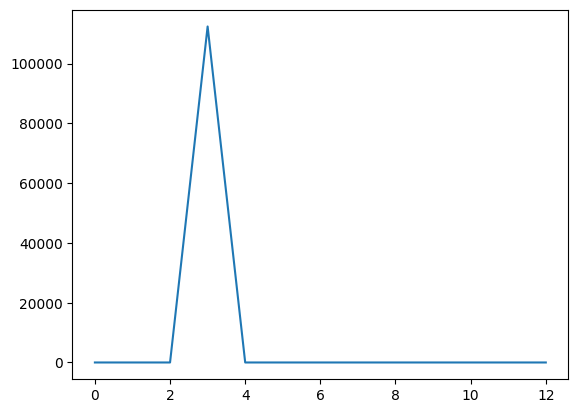

Epoch:    0 | Total Loss:   0.0849 | Budget Loss:  0.00 | Long Fairness Loss:  0.0836 | Improvement Loss:  0.6348 | Time:  185.8 | Patience: 1
Checkpoint saved at epoch 1
Epoch:   10 | Total Loss:   0.1013 | Budget Loss:  0.00 | Long Fairness Loss:  0.1000 | Improvement Loss:  0.5481 | Time:  181.5 | Patience: 9
Early stopping
 Last save: 1
Last saved epoch:  1


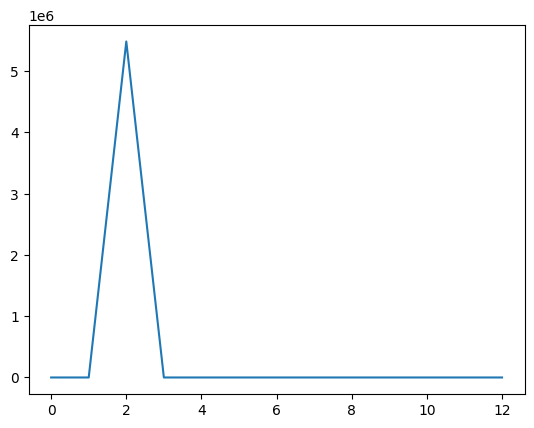

Epoch:    0 | Total Loss:   0.0811 | Budget Loss:  0.00 | Long Fairness Loss:  0.0752 | Improvement Loss:  0.6602 | Time:  182.2 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 7
Epoch:   10 | Total Loss:   0.0804 | Budget Loss:  0.00 | Long Fairness Loss:  0.0738 | Improvement Loss:  0.7122 | Time:  178.1 | Patience: 3
Early stopping
 Last save: 7
Last saved epoch:  7


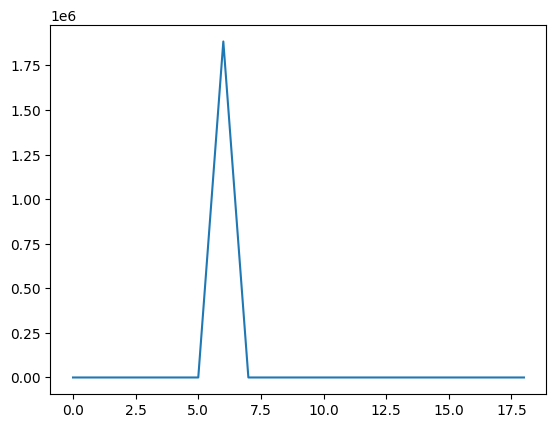

Epoch:    0 | Total Loss:   0.0916 | Budget Loss:  0.00 | Long Fairness Loss:  0.0884 | Improvement Loss:  0.6133 | Time:  182.6 | Patience: 1
Checkpoint saved at epoch 1
Checkpoint saved at epoch 4
Checkpoint saved at epoch 7
Checkpoint saved at epoch 9
Epoch:   10 | Total Loss:   0.0622 | Budget Loss:  0.00 | Long Fairness Loss:  0.0584 | Improvement Loss:  0.8063 | Time:  171.9 | Patience: 1
Checkpoint saved at epoch 11
Checkpoint saved at epoch 13
Checkpoint saved at epoch 14
Checkpoint saved at epoch 15
Checkpoint saved at epoch 16
Epoch:   20 | Total Loss:   0.0488 | Budget Loss:  0.00 | Long Fairness Loss:  0.0442 | Improvement Loss:  0.8235 | Time:  178.4 | Patience: 4
Early stopping
 Last save: 16
Last saved epoch:  16


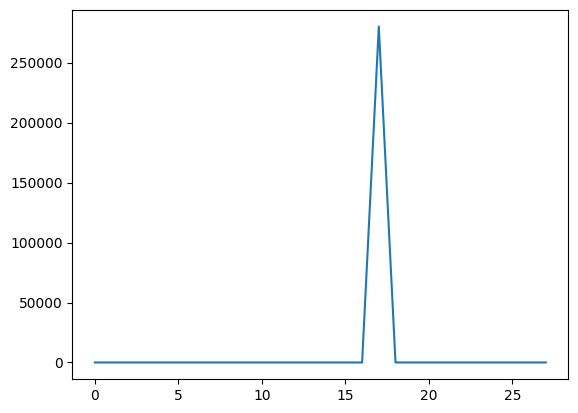

In [ ]:
import time
t0 = original_pairs
df = pd.DataFrame(t0)
df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
df.to_csv('taiwan.csv')   
data_module = vaca_dataset(1, t0, device, 'taiwan')
loader = data_module.train_dataloader()
data_module.batch_size = 1
loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
loader = data_module.train_dataloader()
loss_fn = torch.nn.MSELoss()
net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
model = 'LSTM_CLF'
dataset = 'taiwan'
config = load_config()

s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

b_list = [1, 2, 3, 4]
for b in b_list:
    budget = b*seq_len
    df = pd.DataFrame(t0)
    df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
    df.to_csv('taiwan.csv')   
    data_module = vaca_dataset(1, t0, device, 'taiwan')
    loader = data_module.train_dataloader()
    data_module.batch_size = 1
    loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
    loss_fn = torch.nn.MSELoss()
    net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)
    loss_weights = get_loss_weights(model, dataset, budget, config)
    loss_weights = [x/sum(loss_weights) for x in loss_weights]
    imp_w, lt_w, st_w = loss_weights    

    efforts_path = log_dir / (f"LSTM_clf_effort_model_" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_lt-w_" + str(lt_w) + "_st-w_" + str(st_w) + ".pth")
    checkpoint_path = log_dir / (f"LSTM_clf_effort_model_" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_lt-w_" + str(lt_w) + "_st-w_" + str(st_w) + "_checkpoint.pth")
    best_loss = float('inf')
    patience = 0
    last_epoch=0
    

    hist_loss = []
    for epoch in range(last_epoch, 100):
        epoch_start = time.time()
        net.train()
        efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
        optimizer.zero_grad()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts.view(len(loader), seq_len-1, 2), seq_len, dataset ,device)
        improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
        lt_fairness = compute_distance_loss(data)
        st_fairness = compute_st_loss(s, y_hat)
        t_loss = 10000*budget_penalty(efforts, budget*0.95) + imp_w*improvement_loss + lt_w*lt_fairness + st_w*st_fairness
        
        t_loss.backward()
        optimizer.step()

        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        
        optimizer.step()
        net.eval()
        with torch.no_grad():
            val_loss = 0.0
            val_loader = data_module.val_dataloader()
            data_module.batch_size = 1
            val_loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
            val_efforts = net(tensor(val_loader.dataset.X).view(len(val_loader.dataset), 1, int(x_dim*2)+3).to(device))
            val_y, val_x, val_data = intervene(data_module, val_loader, model_vaca, generator, clf, val_efforts, seq_len, 'taiwan', device)
            val_loss = 10000*budget_penalty(val_efforts, budget*0.95) +imp_w*loss_fn(val_y, torch.ones_like(val_y)) + lt_w*compute_distance_loss(val_data) + st_w*compute_st_loss(val_s, val_y)

        scheduler.step(val_loss)
        df = pd.DataFrame(t0)
        df = df.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
        df.to_csv('taiwan.csv')   
        data_module = vaca_dataset(1, t0, device, 'taiwan')
        epoch_end = time.time()
        hist_loss.append(t_loss.item())
        if (t_loss < best_loss and epoch > 0):
            best_loss = t_loss
            patience = 0
            torch.save(net.state_dict(), efforts_path)
            save_checkpoint(epoch, net, optimizer, best_loss, checkpoint_path)
            e = epoch
            
        
        else:
            patience += 1
            if (patience > 10 and 10000*budget_penalty(efforts, budget*.95) < 0.01):
                print('Early stopping')
                print(f' Last save: {e}')
                break

        if epoch % 10 == 0:
            print(f'Epoch: {epoch: 4.0f} | Total Loss: {t_loss: 8.4f} | Budget Loss: {10000*budget_penalty(efforts, budget*.95) : 3.2f} | Long Fairness Loss: {lt_fairness: 3.4f} | Improvement Loss: {improvement_loss: 3.4f} | Time: {epoch_end - epoch_start: 3.1f} | Patience: {patience}')

    print('Last saved epoch: ', e)

    plt.plot(np.arange(0, len(hist_loss), 1), hist_loss)
    plt.show()


In [ ]:
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
data_module = vaca_dataset(1, t0, device)
original_pairs = data_module.total_dataloader().dataset.X
loader = data_module.test_dataloader()
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
data_module.batch_size = 1
loss_fn = torch.nn.MSELoss(reduction='mean')
net = effortLSTM(data_module, loader, seq_len, device)
budget = 1*seq_len
efforts_path = log_dir / (f"LSTM_effort_model" + "_budget_" + str(budget) + ".pth")

net.load_state_dict(torch.load(efforts_path, map_location=device))
original_data = data_module.total_dataloader().dataset.X
s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

efforts = net(tensor(loader.dataset.X[:,:x_dim+2]).view(len(loader.dataset), 1, x_dim+2).to(device))
y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, device)
improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
st_fairness = compute_st_loss(s, y_hat)
lt_fairness = compute_distance_loss(data)
t_loss = 10000*budget_penalty(efforts, budget) + 0.05*improvement_loss + 2*lt_fairness + 0.05*st_fairness

df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
print(f'Total Loss: {t_loss: 8.2f} | Improvement Loss: {improvement_loss: 3.4} | Budget Loss: {10000*budget_penalty(efforts, budget) : 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Long Fairness Loss: {lt_fairness: 3.4f}')
timeline = range(seq_len)
data_t = torch.empty(len(loader), 1, x_dim + 2)
f_model = []
for i in range(seq_len):
    data_t = torch.cat([s.view(len(loader), 1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
    distance = compute_distance_loss(data_t)
    f_model.append(distance.item())
f_model[0] = f_test_og[0]
plt.plot(timeline, f_test_og, label='Original Fairness')
plt.plot(timeline, f_model, label='Post Interventions Fairness')
plt.title(f'Budget = {budget}')
plt.legend()
plt.show()



: 

In [ ]:
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
data_module = vaca_dataset(1, t0, device)
original_pairs = data_module.total_dataloader().dataset.X
loader = data_module.test_dataloader()
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
data_module.batch_size = 1
loss_fn = torch.nn.MSELoss(reduction='mean')
net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
budget = 1*seq_len
efforts_path = log_dir / (f"LSTM_clf_effort_model_" + "_budget_" + str(budget) + ".pth")

net.load_state_dict(torch.load(efforts_path, map_location=device))
original_data = data_module.total_dataloader().dataset.X
s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

efforts = net(tensor(loader.dataset.X[:,:x_dim+2]).view(len(loader.dataset), 1, x_dim+2).to(device))
y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, device)
improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
st_fairness = compute_st_loss(s, y_hat)
lt_fairness = compute_distance_loss(data)
t_loss = 10000*budget_penalty(efforts, budget) + 0.05*improvement_loss + 2*lt_fairness + 0.05*st_fairness

df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
print(f'Total Loss: {t_loss: 8.2f} | Improvement Loss: {improvement_loss: 3.4} | Budget Loss: {10000*budget_penalty(efforts, budget) : 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Long Fairness Loss: {lt_fairness: 3.4f}')
timeline = range(seq_len)
data_t = torch.empty(len(loader), 1, x_dim + 2)
f_model = []
for i in range(seq_len):
    data_t = torch.cat([s.view(len(loader), 1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
    distance = compute_distance_loss(data_t)
    f_model.append(distance.item())
f_model[0] = f_test_og[0]
plt.plot(timeline, f_test_og, label='Original Fairness')
plt.plot(timeline, f_model, label='Post Interventions Fairness')
plt.title(f'Budget = {budget}')
plt.legend()
plt.show()



: 

In [ ]:
df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
data_module = vaca_dataset(1, t0, device)
original_pairs = data_module.total_dataloader().dataset.X
loader = data_module.test_dataloader()
loader.dataset.set_intervention({'x1': 0}, is_noise=True)
data_module.batch_size = 1
loss_fn = torch.nn.MSELoss(reduction='mean')
net = effortLSTM(data_module, loader, seq_len, device)
budget = 1*seq_len
efforts_path = log_dir / (f"LSTM_effort_model" + "_budget_" + str(budget) + ".pth")

net.load_state_dict(torch.load(efforts_path, map_location=device))
original_data = data_module.total_dataloader().dataset.X
s = tensor(loader.dataset.X[:,0]).to(device)
y0 = tensor(loader.dataset.X[:,x_dim+1]).to(device)

efforts = net(tensor(loader.dataset.X[:,:x_dim+2]).view(len(loader.dataset), 1, x_dim+2).to(device))
y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, device)
improvement_loss = loss_fn(y_hat, torch.ones_like(y_hat))
st_fairness = compute_st_loss(s, y_hat)
lt_fairness = compute_distance_loss(data)
t_loss = 10000*budget_penalty(efforts, budget) + 0.05*improvement_loss + 2*lt_fairness + 0.05*st_fairness

df = pd.DataFrame(t0)
df = df.set_axis(['s', 'x1', 'z1', 'y1', 'x2', 'z2', 'y2'], axis=1)
df.to_csv('pairs.csv')
print(f'Total Loss: {t_loss: 8.2f} | Improvement Loss: {improvement_loss: 3.4} | Budget Loss: {10000*budget_penalty(efforts, budget) : 3.4f} | Short Fairness Loss: {st_fairness: 3.4f} | Long Fairness Loss: {lt_fairness: 3.4f}')
timeline = range(seq_len)
data_t = torch.empty(len(loader), 1, x_dim + 2)
f_model = []
for i in range(seq_len):
    data_t = torch.cat([s.view(len(loader), 1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
    distance = compute_distance_loss(data_t)
    f_model.append(distance.item())
f_model[0] = f_test_og[0]
plt.plot(timeline, f_test_og, label='Original Fairness')
plt.plot(timeline, f_model, label='Post Interventions Fairness')
plt.title(f'Budget = {budget}')
plt.legend()
plt.show()



: 

In [ ]:
pos_efforts = efforts.view(len(loader), seq_len, 2)[s.squeeze() == 1, :].view(-1, 2)
neg_efforts = efforts.view(len(loader), seq_len, 2)[s.squeeze() == 0, :].view(-1, 2)
print(f'Positive Efforts: {torch.mean(torch.norm(pos_efforts, 2, dim=1), dim=0)}')
print(f'Negative Efforts: {torch.mean(torch.norm(neg_efforts, 2, dim=1), dim=0)}')
plt.scatter(pos_efforts[:,0].detach().cpu().numpy(), pos_efforts[:,1].detach().cpu().numpy(), color = 'blue')
plt.scatter(neg_efforts[:,0].detach().cpu().numpy(), neg_efforts[:,1].detach().cpu().numpy(), color = 'red')

: 

In [ ]:
steps = [0, 5, 9]
x_hat_test = x_hat.detach().cpu().numpy()
y_hat_test = y_hat.detach().cpu().numpy()
s_test = s.detach().cpu().numpy()

for i in steps:
    x_neg = x_hat_test[s_test == 0, i, :]
    y_neg = y_hat_test[s_test == 0, i]
    y_neg = y_neg.squeeze()
    x_pos = x_hat_test[s_test == 1, i, :]
    y_pos = y_hat_test[s_test == 1, i]
    y_pos = y_pos.squeeze()

    plt.scatter(x_neg[y_neg==0, 0], x_neg[y_neg==0, 1], marker='x', color='red')
    plt.scatter(x_neg[y_neg==1, 0], x_neg[y_neg==1, 1], marker='x', color='blue')
    plt.scatter(x_pos[y_pos==0, 0], x_pos[y_pos==0, 1], marker='o', color='red')
    plt.scatter(x_pos[y_pos==1, 0], x_pos[y_pos==1, 1], marker='o', color='blue')
    plt.title(f't={i}, budget = {budget}')
    plt.savefig("t=" + str(i) + ", budget = " +str(budget) +".png")
    plt.show()

: 

In [ ]:
from colour import Color
red = Color("blue")
colors = list(red.range_to(Color("grey"), seq_len))
for i in range(seq_len):
    plt.scatter(x_hat_test[1, i,0], x_hat_test[1, i,1], color = colors[i].hex)

blue = Color("red")
colors = list(blue.range_to(Color("grey"), seq_len))
for i in range(seq_len):
    plt.scatter(x_hat_test[0, i,0], x_hat_test[0, i,1], color = colors[i].hex)
efforts[0].view(10,2)

: 

## Testing

In [102]:
seeds = list(range(2031, 2061))
og_fairness = np.empty((len(seeds), seq_len))
model_fairness_lstm_clf = np.empty((len(seeds), seq_len))
short_term_fairness_clf = np.empty((len(seeds), seq_len))
short_term_og = np.empty((len(seeds), seq_len))
loader = data_module.total_dataloader()
net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
n = 200
budget = 1*seq_len
efforts_lstm_clf = torch.empty(len(seeds), n, seq_len-1, 2)
efforts_path = log_dir / (f"LSTM_clf_effort_model_" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + ".pth")
net.load_state_dict(torch.load(efforts_path, map_location=device))
for seed in seeds:
    t1 = time.time()
    torch.manual_seed(seed) 
    np.random.seed(seed)
    s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=seed)
    gan_noise = torch.randn(len(s0), seq_len-1, x_dim).to(device)
    x0 = torch.tensor(x0, dtype=torch.float32).to(device)
    s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
    x_gan, _, y_gan = generator(x0, gan_noise, s0, unfair_clf.to(device))
    p_to_csv(s0.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'taiwan')
    #
    for i in range(seq_len):
        gan_output = torch.cat([s0, x_gan[:, i, :], y_gan[:, i, :]], dim=1)
        short_loss = compute_st_loss(s0, y_gan[:, i, :])
        distance = compute_distance_loss(gan_output.to(device))
        short_term_og[seed-2031, i] = short_loss.item()
        og_fairness[seed-2031, i] = distance.item()
    data_module = vaca_dataset(1, y0, device, 'taiwan')
    loader = data_module.total_dataloader()
    loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
    efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
    efforts_lstm_clf[seed-2031] = efforts.view(len(loader), seq_len-1, 2).detach().cpu()
    y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, 'taiwan', device)
    for i in range(seq_len-1):
        data_t = torch.cat([data[:, 0].view(n,1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
        st_fairness = compute_st_loss(data[:, 0].view(n,1).to(device), y_hat[:,i].view(n,1).to(device))
        short_term_fairness_clf[seed-2031, i+1] = st_fairness.item()
        distance = compute_distance_loss(data_t)
        model_fairness_lstm_clf[seed-2031, i+1] = distance.item()

    t2 = time.time()
    print(f'Seed: {seed} | Time: {t2 - t1: 4.2f}')
    

Seed: 2031 | Time:  49.05
Seed: 2032 | Time:  47.55
Seed: 2033 | Time:  48.86
Seed: 2034 | Time:  51.81
Seed: 2035 | Time:  48.79
Seed: 2036 | Time:  48.75
Seed: 2037 | Time:  50.53
Seed: 2038 | Time:  50.22
Seed: 2039 | Time:  50.34
Seed: 2040 | Time:  64.09
Seed: 2041 | Time:  55.09
Seed: 2042 | Time:  50.15
Seed: 2043 | Time:  52.63
Seed: 2044 | Time:  49.65
Seed: 2045 | Time:  50.65
Seed: 2046 | Time:  50.94
Seed: 2047 | Time:  51.83
Seed: 2048 | Time:  49.44
Seed: 2049 | Time:  49.67
Seed: 2050 | Time:  50.09
Seed: 2051 | Time:  50.86
Seed: 2052 | Time:  50.76
Seed: 2053 | Time:  51.61
Seed: 2054 | Time:  54.72
Seed: 2055 | Time:  50.24
Seed: 2056 | Time:  51.88
Seed: 2057 | Time:  48.84
Seed: 2058 | Time:  50.61
Seed: 2059 | Time:  51.28
Seed: 2060 | Time:  49.82


In [ ]:
def run_tradeoff_experiments(model, generator, seq_len, budget, n, lambda_lt, lambda_st, log_dir, device):
    seeds = list(range(2031, 2061))
    og_fairness = np.empty((len(seeds), seq_len))
    model_fairness = np.empty((len(seeds), seq_len))
    short_term_fairness = np.empty((len(seeds), seq_len))
    short_term_og = np.empty((len(seeds), seq_len))
    data_module = vaca_dataset(1, y0, device, dataset)
    loader = data_module.total_dataloader()
    if model == "CLF":
        net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
        efforts_path = log_dir / (f"LSTM_clf_effort_model_" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_lt-w_" + str(lambda_lt).replace(".", "_") + "_st-w_" + str(lambda_st).replace(".", "_") + ".pth")
    elif model == "LSTM":
        net = effortLSTM(data_module, loader, seq_len, device)
        efforts_path = log_dir / (f"LSTM_effort_model" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + "_lt-w_" + str(lambda_lt).replace(".", "_") + "_st-w_" + str(lambda_st).replace(".", "_") + ".pth")
    else:
        raise Exception("model is not implemented")
    net.load_state_dict(torch.load(efforts_path, map_location=device))
    for seed in seeds:
        torch.manual_seed(seed) 
        np.random.seed(seed)
        if dataset == 'taiwan':
            s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=seed)
        elif dataset == 'toy':
            s0, x0, y0 = gen_gaussian(int(n/2), seed=seed)
        gan_noise = torch.randn(len(s0), seq_len-1, x_dim).to(device)
        x0 = torch.tensor(x0, dtype=torch.float32).to(device)
        s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
        x_gan, _, y_gan = generator(x0, gan_noise, s0, unfair_clf.to(device))
        p_to_csv(s0.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], dataset)
        #
        for i in range(seq_len):
            gan_output = torch.cat([s0, x_gan[:, i, :], y_gan[:, i, :]], dim=1)
            short_loss = compute_st_loss(s0, y_gan[:, i, :])
            distance = compute_distance_loss(gan_output.to(device))
            short_term_og[seed-2031, i] = short_loss.item()
            og_fairness[seed-2031, i] = distance.item()
        data_module = vaca_dataset(1, y0, device, dataset)
        loader = data_module.total_dataloader()
        if dataset == "taiwan":
            loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
        elif dataset == 'toy':
            loader.dataset.set_intervention({'x2': 0, 'z2': 0})
        efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
        efforts_lstm_clf[seed-2031] = efforts.view(len(loader), seq_len-1, 2).detach().cpu()
        y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, dataset, device)
        for i in range(seq_len-1):
            data_t = torch.cat([data[:, 0].view(n,1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
            st_fairness = compute_st_loss(data[:, 0].view(n,1).to(device), y_hat[:,i].view(n,1).to(device))
            short_term_fairness[seed-2031, i+1] = st_fairness.item()
            distance = compute_distance_loss(data_t)
            model_fairness[seed-2031, i+1] = distance.item()
    lt_fairness_final = np.mean(model_fairness[:, -1])
    st_fairness_avg = np.mean(np.mean(short_term_fairness, axis = 0))
    original_lt_fairness = np.mean(og_fairness[:, -1])
    original_st_fairness = np.mean(np.mean(short_term_og, axis=0))
    new_data = pd.DataFrame({'model': model, 'lt_lambda': lambda_lt, 'st_lambda': lambda_st, 'lt_loss': lt_fairness_final, 'st_loss': st_fairness_avg})
    tradeoff_path = 'tradeoff_results.csv'
    if os.path.exists(tradeoff_path):
        existing_data = pd.read_csv(tradeoff_path)
        updated_data = pd.concat([existing_data, new_data], ignore_index=True).drop_duplicates()
        updated_data.to_csv(tradeoff_path, index=False)
    else:
        new_data.to_csv(tradeoff_path, index=False)

/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/.venv/lib/python3.8/site-packages/numpy/core/_methods.py:239: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


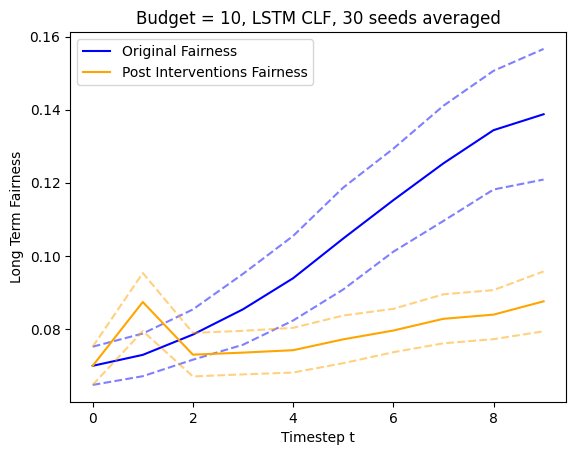

In [103]:
og_fairness_tl = np.mean(og_fairness, axis=0)
model_fairness_tl_lstm_clf = np.mean(model_fairness_lstm_clf, axis=0)
og_top = og_fairness_tl + np.std(og_fairness, axis=0)
og_bottom = og_fairness_tl - np.std(og_fairness, axis=0)
model_top_lstm_clf = model_fairness_tl_lstm_clf + np.std(model_fairness_lstm_clf, axis=0)
model_bottom_lstm_clf = model_fairness_tl_lstm_clf - np.std(model_fairness_lstm_clf, axis=0)
model_fairness_tl_lstm_clf[0] = og_fairness_tl[0]
model_bottom_lstm_clf[0] = og_bottom[0]
model_top_lstm_clf[0] = og_top[0]
timeline = range(seq_len)

plt.plot(timeline, og_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_bottom,  color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')
plt.plot(timeline, model_top_lstm_clf, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom_lstm_clf, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl_lstm_clf, color='orange', label='Post Interventions Fairness')
plt.title(f'Budget = {budget}, LSTM CLF, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Long Term Fairness')
plt.legend()
plt.show()

In [54]:
seeds = list(range(2031, 2061))
og_fairness = np.empty((len(seeds), seq_len))
n = 200
model_fairness_lstm = np.empty((len(seeds), seq_len))
short_term_og = np.empty((len(seeds), seq_len))
short_term_fairness = np.empty((len(seeds), seq_len))   
dataset = 'taiwan'
loader = data_module.total_dataloader()
net = effortLSTM(data_module, loader, seq_len, device)
budget = 1*seq_len
efforts_lstm = torch.empty(len(seeds), n, seq_len-1, len(loader.dataset.nodes_to_intervene))
efforts_path = log_dir / (f"LSTM_effort_model" + dataset + "_budget_" + str(budget) + "_eps_" + str(eps) + "_b_" + str(bet) + ".pth")
net.load_state_dict(torch.load(efforts_path, map_location=device))
for seed in seeds:
    t1 = time.time()
    torch.manual_seed(seed)
    np.random.seed(seed)
    s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=seed)
    gan_noise = torch.randn(len(s0), seq_len-1, x_dim).to(device)
    x0 = torch.tensor(x0, dtype=torch.float32).to(device)
    s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
    x_gan, _, y_gan = generator(x0, gan_noise, s0, unfair_clf.to(device))
    p_to_csv(s0.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'taiwan')
    #
    for i in range(seq_len):
        gan_output = torch.cat([s0, x_gan[:, i, :], y_gan[:, i, :]], dim=1)
        short_loss = compute_st_loss(s0, y_gan[:, i, :])
        distance = compute_distance_loss(gan_output.to(device))
        short_term_og[seed-2031, i] = short_loss.item()
        og_fairness[seed-2031, i] = distance.item()
    data_module = vaca_dataset(1, y0, device, 'taiwan')
    loader = data_module.total_dataloader()
    loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
    efforts = net(tensor(loader.dataset.X).view(len(loader.dataset), 1, int(x_dim*2)+3).to(device))
    efforts_lstm[seed-2031] = efforts.view(len(loader), seq_len-1, 2).detach().cpu()
    y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, dataset, device)
    for i in range(seq_len-1):
        data_t = torch.cat([data[:, 0].view(len(s0),1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
        short_loss = compute_st_loss(data[:, 0].view(n,1).to(device), y_hat[:, i].view(n,1).to(device))
        distance = compute_distance_loss(data_t)
        model_fairness_lstm[seed-2031, i+1] = distance.item()
        short_term_fairness[seed-2031, i+1] = short_loss.item()

    t2 = time.time()
    print(f'Seed: {seed} | Time: {t2 - t1: 4.2f}')
    

Seed: 2031 | Time:  65.53
Seed: 2032 | Time:  62.52
Seed: 2033 | Time:  62.71
Seed: 2034 | Time:  64.81
Seed: 2035 | Time:  61.90
Seed: 2036 | Time:  60.00
Seed: 2037 | Time:  63.32
Seed: 2038 | Time:  62.58
Seed: 2039 | Time:  63.60
Seed: 2040 | Time:  81.97
Seed: 2041 | Time:  66.96
Seed: 2042 | Time:  64.10
Seed: 2043 | Time:  68.19
Seed: 2044 | Time:  66.62
Seed: 2045 | Time:  63.83
Seed: 2046 | Time:  63.78
Seed: 2047 | Time:  65.16
Seed: 2048 | Time:  63.75
Seed: 2049 | Time:  64.68
Seed: 2050 | Time:  61.24
Seed: 2051 | Time:  63.27
Seed: 2052 | Time:  64.18
Seed: 2053 | Time:  66.29
Seed: 2054 | Time:  69.98
Seed: 2055 | Time:  64.23
Seed: 2056 | Time:  62.19
Seed: 2057 | Time:  64.64
Seed: 2058 | Time:  62.40
Seed: 2059 | Time:  67.11
Seed: 2060 | Time:  62.51


In [55]:
og_fairness_tl = np.mean(og_fairness, axis=0)
model_fairness_tl_lstm = np.mean(model_fairness_lstm, axis=0)
og_top = og_fairness_tl + np.std(og_fairness, axis=0)
og_bottom = og_fairness_tl - np.std(og_fairness, axis=0)
model_top_lstm = model_fairness_tl_lstm + np.std(model_fairness_lstm, axis=0)
model_bottom_lstm = model_fairness_tl_lstm - np.std(model_fairness_lstm, axis=0)
model_fairness_tl_lstm[0] = og_fairness_tl[0]
model_bottom_lstm[0] = og_bottom[0]
model_top_lstm[0] = og_top[0]


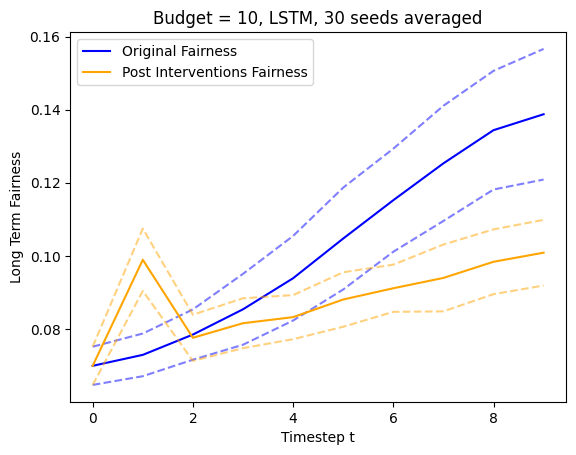

In [56]:
timeline = range(seq_len)
plt.plot(timeline, og_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_bottom,  color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')
plt.plot(timeline, model_top_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl_lstm, color='orange', label='Post Interventions Fairness')
plt.title(f'Budget = {budget}, LSTM, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Long Term Fairness')
plt.legend()
plt.show()

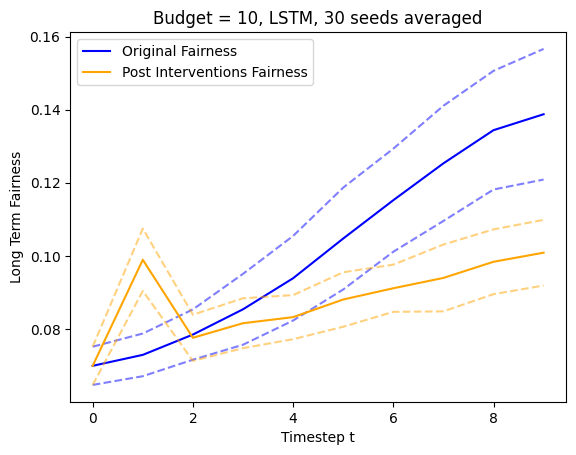

In [57]:
timeline = range(seq_len)
plt.plot(timeline, og_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_bottom,  color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')
plt.plot(timeline, model_top_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl_lstm, color='orange', label='Post Interventions Fairness')
plt.title(f'Budget = {budget}, LSTM, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Long Term Fairness')
plt.legend()
plt.show()

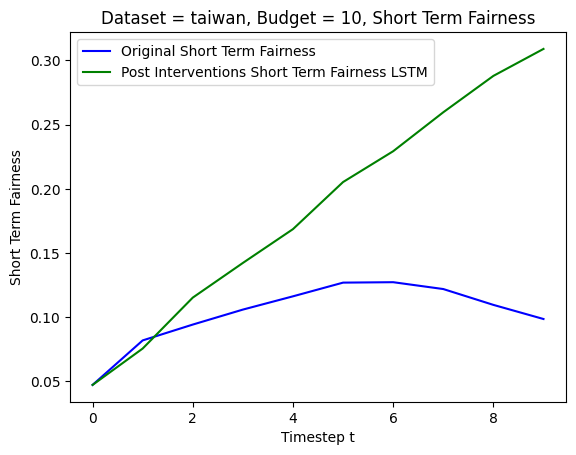

In [ ]:
og_short_term_tl = np.mean(short_term_og, axis=0)
short_term_clf_tl = np.mean(short_term_fairness_clf, axis=0)
short_term_lstm_tl = np.mean(short_term_fairness, axis=0)
short_term_clf_tl[0] = og_short_term_tl[0]
short_term_lstm_tl[0] = og_short_term_tl[0]

plt.plot(timeline, og_short_term_tl, color='blue', label='Original Short Term Fairness')
plt.plot(timeline, short_term_clf_tl, color='orange', label='Post Interventions Short Term Fairness LSTM CLF')
plt.plot(timeline, short_term_lstm_tl, color='green', label='Post Interventions Short Term Fairness LSTM')
plt.title(f'Dataset = {dataset}, Budget = {budget}, Short Term Fairness')
plt.xlabel('Timestep t')
plt.ylabel('Short Term Fairness')
plt.legend()
plt.savefig('Taiwan short_term_fairness.png')
plt.show()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <BarContainer object of 20 artists>)

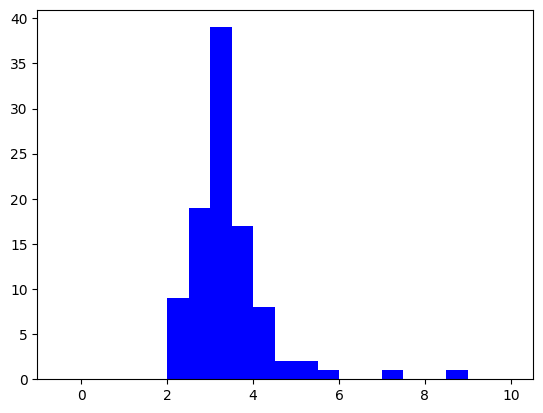

: 

In [ ]:
for t in range(seq_len):
    for i in range(len(seeds)):
        efforts_lstm_clf[i, :, t, 0] = efforts_lstm_clf[i, :, t, 0] - efforts_lstm_clf[i, 0, t, 0]
        efforts_lstm_clf[i, :, t, 1] = efforts_lstm_clf[i, :, t, 1] - efforts_lstm_clf[i, 0, t, 1]
        efforts_lstm[i, :, t, 0] = efforts_lstm[i, :, t, 0] - efforts_lstm[i, 0, t, 0]
        efforts_lstm[i, :, t, 1] = efforts_lstm[i, :, t, 1] - efforts_lstm[i, 0, t, 1]
    pos_efforts = efforts_lstm.view(n, seq_len, 2)[s0.squeeze() == 1, :]
ps = []
for i in range(len(pos_efforts)):
    ps.append(torch.sum(torch.abs(pos_efforts[i])).item())

plt.hist(ps, color='blue', range=(0, 10), bins=20)

neg_efforts = efforts.view(n, seq_len, 2)[s0.squeeze() == 0, :]
ns = []
for i in range(len(neg_efforts)):
    ns.append(torch.sum(torch.abs(neg_efforts[i])).item())

plt.hist(ns, color='red', alpha=0.7, range=(0, 0), bins=20)

In [ ]:
seeds = list(range(2031, 2061))
og_fairness = np.empty((len(seeds), seq_len))
n = 200
model_fairness = np.empty((len(seeds), seq_len))
loader = data_module.total_dataloader()
net = effortNN(data_module, loader, seq_len, device)
budget = 2*seq_len
efforts_nn = torch.empty(len(seeds), n, seq_len-1, len(loader.dataset.nodes_to_intervene))
efforts_path = log_dir / (f"effort_model" + dataset + "_budget_" + str(budget) + ".pth")
net.load_state_dict(torch.load(efforts_path, map_location=device))
for seed in seeds:
    t1 = time.time()
    torch.manual_seed(seed)
    np.random.seed(seed)
    s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=seed)
    gan_noise = torch.randn(len(s0), seq_len-1, x_dim).to(device)
    x0 = torch.tensor(x0, dtype=torch.float32).to(device)
    s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
    x_gan, _, y_gan = generator(x0, gan_noise, s0, unfair_clf.to(device))
    p_to_csv(s0.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'taiwan')
    #
    for i in range(seq_len):
        gan_output = torch.cat([s0, x_gan[:, i, :], y_gan[:, i, :]], dim=1)
        distance = compute_distance_loss(gan_output.to(device))
        og_fairness[seed-2031, i] = distance.item()
    data_module = vaca_dataset(1, y0, device, 'taiwan')
    loader = data_module.total_dataloader()
    loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
    efforts = net(tensor(loader.dataset.X).to(device))
    efforts_nn[seed-2031] = efforts.view(len(loader), seq_len-1, 2).detach().cpu()
    y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, dataset, device)
    for i in range(seq_len-1):
        data_t = torch.cat([data[:, 0].view(len(s0),1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
        distance = compute_distance_loss(data_t)
        model_fairness[seed-2031, i+1] = distance.item()

    t2 = time.time()
    print(f'Seed: {seed} | Time: {t2 - t1: 4.2f}')
    

Seed: 2031 | Time:  51.53
Seed: 2032 | Time:  52.18
Seed: 2033 | Time:  53.05
Seed: 2034 | Time:  54.34
Seed: 2035 | Time:  52.64
Seed: 2036 | Time:  52.93
Seed: 2037 | Time:  54.00
Seed: 2038 | Time:  55.63
Seed: 2039 | Time:  55.46
Seed: 2040 | Time:  68.84
Seed: 2041 | Time:  59.17
Seed: 2042 | Time:  55.56
Seed: 2043 | Time:  53.63
Seed: 2044 | Time:  56.08
Seed: 2045 | Time:  54.35
Seed: 2046 | Time:  55.74
Seed: 2047 | Time:  57.57
Seed: 2048 | Time:  54.72
Seed: 2049 | Time:  54.96
Seed: 2050 | Time:  54.42
Seed: 2051 | Time:  55.11
Seed: 2052 | Time:  56.18
Seed: 2053 | Time:  56.87
Seed: 2054 | Time:  59.40
Seed: 2055 | Time:  55.94
Seed: 2056 | Time:  55.50
Seed: 2057 | Time:  55.35
Seed: 2058 | Time:  54.18
Seed: 2059 | Time:  56.73
Seed: 2060 | Time:  54.81


: 

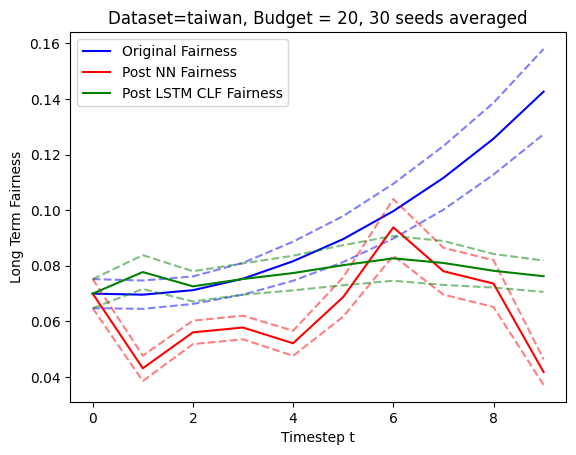

: 

In [ ]:
og_fairness_tl = np.mean(og_fairness, axis=0)
og_top = og_fairness_tl + np.std(og_fairness, axis=0)
og_bottom = og_fairness_tl - np.std(og_fairness, axis=0)
model_fairness_tl = np.mean(model_fairness, axis=0)
model_fairness_tl_lstm_clf = np.mean(model_fairness_lstm_clf, axis=0)
model_top_lstm_clf = model_fairness_tl_lstm_clf + np.std(model_fairness_lstm_clf, axis=0)
model_bottom_lstm_clf = model_fairness_tl_lstm_clf - np.std(model_fairness_lstm_clf, axis=0)

model_top = model_fairness_tl + np.std(model_fairness, axis=0)
model_bottom = model_fairness_tl - np.std(model_fairness, axis=0)
model_fairness_tl[0] = og_fairness_tl[0]
model_bottom[0] = og_bottom[0]
model_top[0] = og_top[0]
model_fairness_tl_lstm_clf[0] = og_fairness_tl[0]
model_bottom_lstm_clf[0] = og_bottom[0]
model_top_lstm_clf[0] = og_top[0]
timeline = range(seq_len)

plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')
plt.plot(timeline, og_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_bottom,  color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl, color='red', label='Post NN Fairness')
plt.plot(timeline, model_top, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom,  color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl_lstm_clf, color='green', label='Post LSTM CLF Fairness')
plt.plot(timeline, model_top_lstm_clf, color='green', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom_lstm_clf,  color='green', linestyle='dashed', alpha=0.5)
plt.title(f'Dataset={dataset}, Budget = {budget}, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Long Term Fairness')
plt.legend()
plt.show()

In [ ]:
seeds = list(range(2021, 2051))
og_fairness = np.empty((len(seeds), seq_len))
n = 200
model_fairness_lstm_clf = np.empty((len(seeds), seq_len))
dataset = 'taiwan'
loader = data_module.total_dataloader()
net = effortLSTM_clf(data_module, seq_len, unfair_clf, device)
budget = 2*seq_len
efforts_lstm_clf = torch.empty(len(seeds), n, seq_len, len(loader.dataset.nodes_to_intervene))
efforts_path = log_dir / (f"LSTM_clf_effort_model_" + dataset + "_budget_" + str(budget) + ".pth")
net.load_state_dict(torch.load(efforts_path, map_location=device))
for seed in seeds:
    t1 = time.time()
    torch.manual_seed(seed)
    np.random.seed(seed)
    s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=seed)
    gan_noise = torch.randn(len(s0), seq_len-1, x_dim).to(device)
    x0 = torch.tensor(x0, dtype=torch.float32).to(device)
    s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
    x_gan, _, y_gan = generator(x0, gan_noise, s0, unfair_clf.to(device))
    t0 = torch.cat([s0, x_gan[:, 0, :], y_gan[:, 0, :]], dim=1)
    t0 = pd.DataFrame(t0.detach().cpu().numpy())
    t0 = t0.set_axis(['SEX', 'LIMIT_BAL_1', 'PAY_AMT1_1', 'PAY_AMT2_1', 'Y_1', 'LIMIT_BAL_2', 'PAY_AMT1_2', 'PAY_AMT2_2', 'Y_2'], axis=1)
    t0.to_csv('taiwan.csv')
    for i in range(seq_len):
        gan_output = torch.cat([s0, x_gan[:, i, :], y_gan[:, i, :]], dim=1)
        distance = compute_distance_loss(gan_output.to(device))
        og_fairness[seed-2021, i] = distance.item()
    data_module = vaca_dataset(1, y0, device, 'taiwan')
    loader = data_module.total_dataloader()
    loader.dataset.set_intervention({'LIMIT_BAL': 0, 'PAY_AMT1': 0}, is_noise=True)
    efforts = net(tensor(loader.dataset.X[:,:x_dim+2]).view(len(loader.dataset), 1, x_dim+2).to(device))
    efforts_lstm_clf[seed-2021] = efforts.view(len(loader), seq_len, 2).detach().cpu()
    y_hat, x_hat, data = intervene(data_module, loader, model_vaca, generator, clf, efforts, seq_len, dataset, device)
    for i in range(seq_len):
        data_t = torch.cat([data[:, 0].view(len(s0),1).to(device), x_hat[:,i,:].to(device), y_hat[:,i].view(len(loader), 1).to(device)], dim=1)
        distance = compute_distance_loss(data_t)
        model_fairness_lstm_clf[seed-2021, i] = distance.item()

    t2 = time.time()
    print(f'Seed: {seed} | Time: {t2 - t1: 4.2f}')
    

ValueError: Length mismatch: Expected axis has 5 elements, new values have 9 elements

: 

In [ ]:
og_fairness_tl = np.mean(og_fairness, axis=0)
model_fairness_tl_lstm = np.mean(model_fairness_lstm, axis=0)
og_top = og_fairness_tl + np.std(og_fairness, axis=0)
og_bottom = og_fairness_tl - np.std(og_fairness, axis=0)
model_top_lstm = model_fairness_tl_lstm + np.std(model_fairness_lstm, axis=0)
model_bottom_lstm = model_fairness_tl_lstm - np.std(model_fairness_lstm, axis=0)
model_fairness_tl_lstm[0] = og_fairness_tl[0]
model_bottom_lstm[0] = og_bottom[0]
model_top_lstm[0] = og_top[0]
model_fairness_tl_lstm_clf = np.mean(model_fairness_lstm_clf, axis=0)
model_top_lstm_clf = model_fairness_tl_lstm_clf + np.std(model_fairness_lstm_clf, axis=0)
model_bottom_lstm_clf = model_fairness_tl_lstm_clf - np.std(model_fairness_lstm_clf, axis=0)
model_fairness_tl_lstm_clf[0] = og_fairness_tl[0]
model_bottom_lstm_clf[0] = og_bottom[0]
model_top_lstm_clf[0] = og_top[0]
model_fairness_tl = np.mean(model_fairness, axis=0)

model_top = model_fairness_tl + np.std(model_fairness, axis=0)
model_bottom = model_fairness_tl - np.std(model_fairness, axis=0)
model_fairness_tl[0] = og_fairness_tl[0]
model_bottom[0] = og_bottom[0]
model_top[0] = og_top[0]


NameError: name 'model_fairness' is not defined

: 

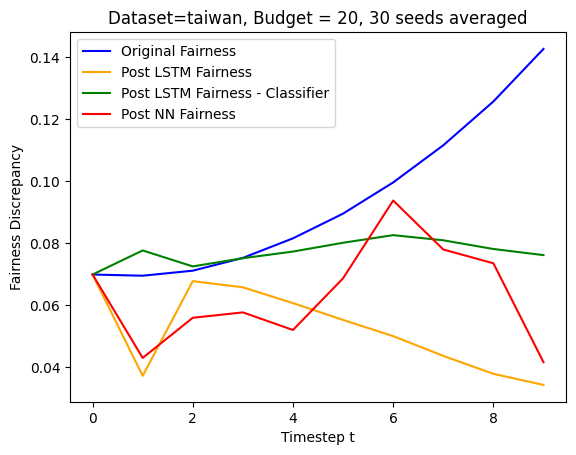

: 

In [ ]:
timeline = range(seq_len)

plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')
plt.plot(timeline, model_fairness_tl_lstm, color='orange', label='Post LSTM Fairness')
plt.plot(timeline, model_fairness_tl_lstm_clf, color='green', label='Post LSTM Fairness - Classifier')
plt.plot(timeline, model_fairness_tl, color='red', label='Post NN Fairness')
plt.title(f'Dataset={dataset}, Budget = {budget}, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Fairness Discrepancy')
plt.legend()
plt.savefig(str(dataset) + 'budget = ' + str(budget) + ' fairness_plot.png')
plt.show()

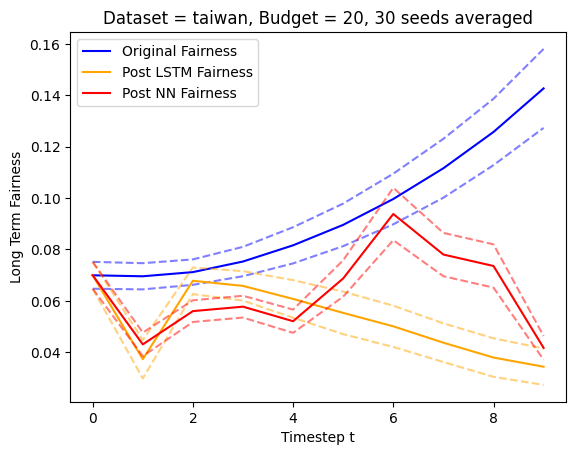

: 

In [ ]:
timeline = range(seq_len)
plt.plot(timeline, og_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_bottom,  color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness')
plt.plot(timeline, model_top_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom_lstm, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl_lstm, color='orange', label='Post LSTM Fairness')
plt.plot(timeline, model_top, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_bottom, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, model_fairness_tl, color='red', label='Post NN Fairness')
plt.title(f'Dataset = {dataset}, Budget = {budget}, 30 seeds averaged')
plt.xlabel('Timestep t')
plt.ylabel('Long Term Fairness')
plt.legend()

plt.show()

## Baseline WIP

In [ ]:
from baseline import *

s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=52)
x, y, unfair_clf = sequential_data(s0, x0, y0, seq_len, l=0.2, noise_factor=0.1, seed=52, ground_truth=False)
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)

train_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)[0:int(n*(1-test_size)), :]
test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)[int(n*(1-test_size)):, :]

train_dataset = SimpleDataset(train_data[:, :-1], train_data[:, -1])
test_dataset = SimpleDataset(test_data[:, :-1], test_data[:, -1])
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)


/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/SimLoan/VACA/baseline.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(self.features[idx], dtype=torch.float32)
/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/SimLoan/VACA/baseline.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(self.labels[idx], dtype=torch.float32)


Epoch 0 p_loss: 0.7444899082183838, f_loss: 0.0
Epoch 10 p_loss: 0.6478418111801147, f_loss: 3.814697265625e-06
Epoch 20 p_loss: 0.6043140888214111, f_loss: 0.0
Epoch 30 p_loss: 0.5839974582195282, f_loss: 3.814697265625e-06
Epoch 40 p_loss: 0.5657027661800385, f_loss: 0.0


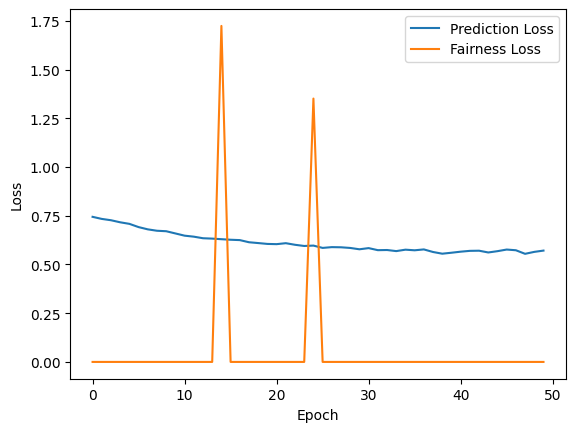

In [ ]:
ei_model = trainer_fb_fair(model, train_loader, [1,2], optim, device, 50, 0.5)

Epoch 0 p_loss: 0.6971106827259064, f_loss: 0.02307307720184326
Epoch 10 p_loss: 0.6541318893432617, f_loss: 0.00266382098197937
Epoch 20 p_loss: 0.6347471177577972, f_loss: 0.0006811767816543579
Epoch 30 p_loss: 0.6419758498668671, f_loss: 0.005568444728851318
Epoch 40 p_loss: 0.6363980174064636, f_loss: 0.0013241618871688843


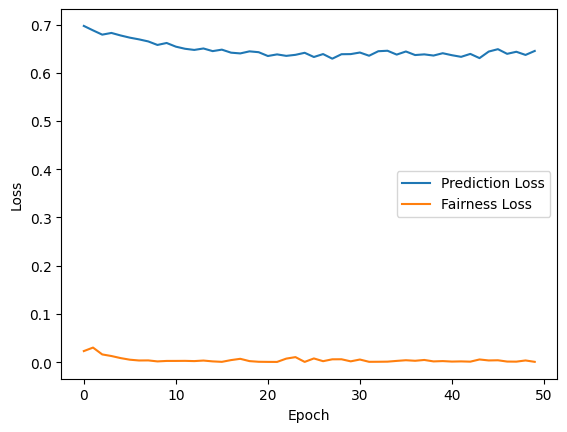

In [ ]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
dp_model = trainer_dp_fair(model, train_loader, optim, device, 50, 0.95)

Epoch 0 p_loss: 0.7092936336994171, f_loss: 0.040272414684295654
Epoch 10 p_loss: 0.7034179270267487, f_loss: 0.003684401512145996
Epoch 20 p_loss: 0.6874613761901855, f_loss: 0.0043220072984695435
Epoch 30 p_loss: 0.6797792017459869, f_loss: 0.001969173550605774
Epoch 40 p_loss: 0.6770937442779541, f_loss: 0.0018141716718673706


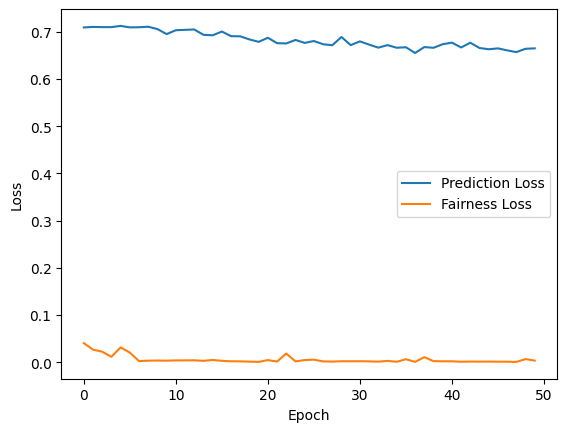

In [ ]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
eo_model = trainer_eo_fair(model, train_loader, optim, device, 50, 0.95)

Epoch 0 p_loss: 0.6880345940589905, f_loss: 0.04154619574546814
Epoch 10 p_loss: 0.6890327334403992, f_loss: 0.00521416962146759
Epoch 20 p_loss: 0.6807580590248108, f_loss: 0.026138678193092346
Epoch 30 p_loss: 0.6797522306442261, f_loss: 0.010598555207252502
Epoch 40 p_loss: 0.6746320426464081, f_loss: 0.01939016580581665


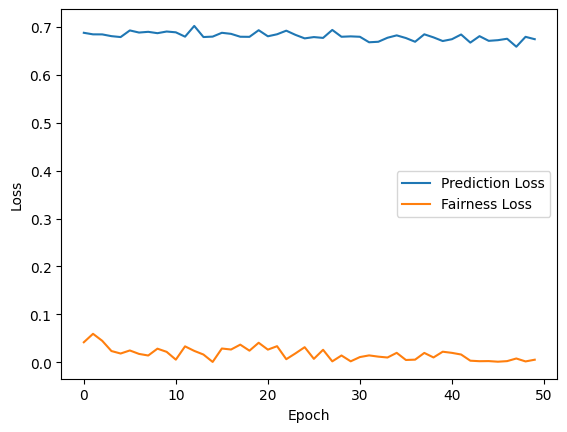

In [ ]:
model = logReg(x_dim + 1).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
eodd_model = trainer_eodd_fair(model, train_loader, optim, device, 50, 0.95)

In [ ]:
seeds = list(range(2031, 2061))
n = 200
EI_fairness = np.empty((len(seeds), seq_len))
efforts_baseline = []
data = np.empty((n, seq_len, x_dim + 2))
loss_fn = torch.nn.MSELoss()
EI_accuracy = np.empty((len(seeds), seq_len))
EI_short_term = np.empty((len(seeds), seq_len))

for seed in seeds:
    s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=seed)
    test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
    test_dataset = SimpleDataset(test_data[:, :-1].detach().cpu().numpy(), test_data[:, -1].detach().cpu().numpy())
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    torch.manual_seed(seed)
    z_mb = torch.randn(len(s0), 1, x_dim).to(device)
    x0 = torch.tensor(x0, dtype=torch.float32).to(device)
    s0 = torch.tensor(s0, dtype=torch.float32).view(len(s0),1).to(device)
    distance = compute_distance_loss(test_data.to(device))
    EI_fairness[seed-2031, 0] = distance.item()    
    _y = ei_model.predict(s0, x0)
    gt_y = clf.predict(s0, x0)
    gt_y = tensor(gt_y).to(device)
    EI_accuracy[seed-2031, 0] = loss_fn(_y, gt_y.to(device)).item()
    EI_short_term[seed-2031, 0] = compute_st_loss(s0, gt_y).item()
        
    x_gan, _, y_gan = generator(x0, z_mb, s0, ei_model.to(device))
    p_to_csv(s0.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'taiwan')
    datamodule = vaca_dataset(1, y0, device, 'taiwan')
    loader = datamodule.total_dataloader()
    loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
    test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    new_budget = tensor([1])
    for i in range(1, seq_len):
        _, e, _data = test_fb_fair(ei_model, test_loader, [1,2], device, delta_effort=new_budget.item())
        effort_indices = ((test_loader.dataset.labels < 1).squeeze()).nonzero()
        efforts = torch.zeros([len(test_loader.dataset), int((x_dim)*2+3)]).to(device)
        efforts[effort_indices[0], x_dim+2:x_dim+4] = e[:, [1, 2]].to(device)
        x_gan_input = intervention_step(loader, model_vaca, datamodule.test_dataset.nodes_to_intervene, efforts, datamodule.test_dataset.nodes_list)
        x_gan_input = x_gan_input.to(device)
        _s = torch.tensor(test_loader.dataset.features[:, 0]).to(device)
        _y = ei_model.predict(_s.unsqueeze(1), x_gan_input.squeeze())
        gt_y = clf.predict(_s.unsqueeze(1), x_gan_input.squeeze())
        gt_y = tensor(gt_y).to(device)
        
        distance = compute_distance_loss(torch.cat([_s.unsqueeze(1), x_gan_input.squeeze(), _y], dim=1).to(device))
        EI_fairness[seed-2031, i] = distance.item()
        new_budget = 1+(1-torch.mean(torch.sum(torch.abs(e), dim=1)))
        data[:, i, 1:-1] = x_gan_input.squeeze().detach().cpu().numpy()
        data[:, i, 0] = _s.detach().cpu().numpy()
        data[:, i, -1] = gt_y.squeeze().detach().cpu().numpy()
        acc = loss_fn(_y, gt_y.to(device))
        EI_accuracy[seed-2031, i] = acc.item()
        EI_short_term[seed-2031, i] = compute_st_loss(_s, _y).item()
        z_mb = torch.randn(len(_s), 1, x_dim).to(device)
        x_gan, _, y_gan = generator(x_gan_input.squeeze().to(device), z_mb, _s.unsqueeze(1), ei_model.to(device))
        p_to_csv(_s.reshape(n,1), x_gan[:, 0:2, :], y_gan[:, 0:2, :], 'taiwan')
        datamodule = vaca_dataset(1, y0, device, 'taiwan')
        loader = datamodule.total_dataloader()
        loader.dataset.set_intervention({'LIMIT_BAL_2': 0, 'PAY_AMT1_2': 0}, is_noise=True)
        test_dataset = SimpleDataset(torch.cat([s0, x_gan[:, -1, :]], dim=1).detach().cpu().numpy(), y_gan[:, -1, :].detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        efforts_baseline.append(e[:, [1, 2]])


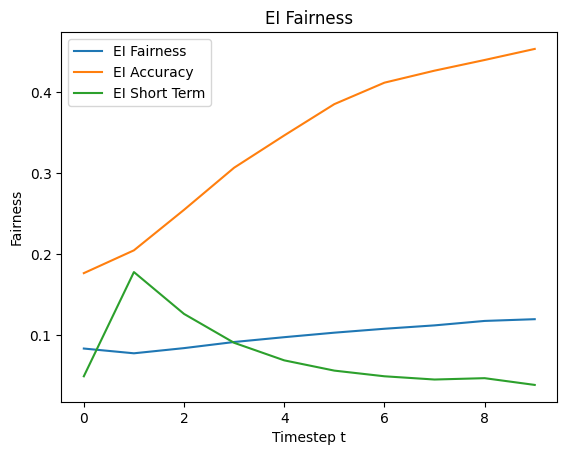

In [ ]:
timeline = range(seq_len)
plt.plot(timeline, np.mean(EI_fairness, axis=0), label='EI Fairness')
plt.plot(timeline, np.mean(EI_accuracy, axis=0), label='EI Accuracy')
plt.plot(timeline, np.mean(EI_short_term, axis=0), label='EI Short Term')
plt.title('EI Fairness')
plt.xlabel('Timestep t')
plt.ylabel('Fairness')
plt.legend()
plt.show()

In [ ]:
seeds = list(range(2031, 2061))
n = 200
DP_fairness = np.empty((len(seeds), seq_len))
data = np.empty((n, seq_len, x_dim + 2))
DP_short_term = np.empty((len(seeds), seq_len))

for seed in seeds:
    s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=seed)
    test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
    test_dataset = SimpleDataset(test_data[:, :-1].detach().cpu().numpy(), test_data[:, -1].detach().cpu().numpy())
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    torch.manual_seed(seed)
    new_budget = tensor([1])
    for i in range(seq_len):
        _, _data = test_dp_fair(dp_model, test_loader, device)
        _s, _x, _y = torch.split(_data, [1, x_dim, 1], dim=1)
        gt_y = clf(_s.to(device), _x.to(device))
        DP_short_term[seed-2031, i] = compute_st_loss(_s, gt_y).item()
        z_mb = torch.randn(len(_s), 1, x_dim).to(device)
        gan_output = generator(_x.to(device), z_mb, _s, dp_model.to(device))
        gan_x = gan_output[0][:, -1, :]
        gan_y = gan_output[1][:, -1, :]
        test_dataset = SimpleDataset(torch.cat([_s, gan_x], dim=1).detach().cpu().numpy(), gan_y.detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        distance = compute_distance_loss(torch.cat([_s, gan_x, gan_y], dim=1).to(device))
        DP_fairness[seed-2031, i] = distance.item()
        data[:, i, :] = torch.cat([_s, gan_x, gan_y], dim=1).detach().cpu().numpy()

In [ ]:
seeds = list(range(2031, 2061))
n = 200
EO_fairness = np.empty((len(seeds), seq_len))
data = np.empty((n, seq_len, x_dim + 2))
EO_short_term = np.empty((len(seeds), seq_len))

for seed in seeds:
    s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=seed)
    test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
    test_dataset = SimpleDataset(test_data[:, :-1].detach().cpu().numpy(), test_data[:, -1].detach().cpu().numpy())
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    torch.manual_seed(seed)
    new_budget = tensor([1])
    for i in range(seq_len):
        _, _data = test_eo_fair(eo_model, test_loader, device)
        _s, _x, _y = torch.split(_data, [1, x_dim, 1], dim=1)
        gt_y = clf(_s.to(device), _x.to(device))
        EO_short_term[seed-2031, i] = compute_st_loss(_s, gt_y).item()
        z_mb = torch.randn(len(_s), 1, x_dim).to(device)
        gan_output = generator(_x.to(device), z_mb, _s, eo_model.to(device))
        gan_x = gan_output[0][:, -1, :]
        gan_y = gan_output[1][:, -1, :]
        test_dataset = SimpleDataset(torch.cat([_s, gan_x], dim=1).detach().cpu().numpy(), gan_y.detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        distance = compute_distance_loss(torch.cat([_s, gan_x, gan_y], dim=1).to(device))
        EO_fairness[seed-2031, i] = distance.item()
        data[:, i, :] = torch.cat([_s, gan_x, gan_y], dim=1).detach().cpu().numpy()

In [ ]:
seeds = list(range(2031, 2061))
n = 200
EODD_fairness = np.empty((len(seeds), seq_len))
data = np.empty((n, seq_len, x_dim + 2))
EODD_short_term = np.empty((len(seeds), seq_len))

for seed in seeds:
    s0, x0, y0, unfair_clf = sample_taiwan(file_path, int(n/4), seq_len, seed=seed)
    test_data = torch.cat([tensor(s0.reshape(n, 1)), tensor(x0), tensor(y0).reshape(n,1)], dim=1)
    test_dataset = SimpleDataset(test_data[:, :-1].detach().cpu().numpy(), test_data[:, -1].detach().cpu().numpy())
    test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
    torch.manual_seed(seed)
    new_budget = tensor([1])
    for i in range(seq_len):
        _, _data = test_eodd_fair(eodd_model, test_loader, device)
        _s, _x, _y = torch.split(_data, [1, x_dim, 1], dim=1)
        gt_y = clf(_s.to(device), _x.to(device))
        EODD_short_term[seed-2031, i] = compute_st_loss(_s, gt_y).item()
        z_mb = torch.randn(len(_s), 1, x_dim).to(device)
        gan_output = generator(_x.to(device), z_mb, _s, eodd_model.to(device))
        gan_x = gan_output[0][:, -1, :]
        gan_y = gan_output[1][:, -1, :]
        test_dataset = SimpleDataset(torch.cat([_s, gan_x], dim=1).detach().cpu().numpy(), gan_y.detach().cpu().numpy())
        test_loader = DataLoader(test_dataset, batch_size=n, shuffle=False)
        distance = compute_distance_loss(torch.cat([_s, gan_x, gan_y], dim=1).to(device))
        EODD_fairness[seed-2031, i] = distance.item()
        data[:, i, :] = torch.cat([_s, gan_x, gan_y], dim=1).detach().cpu().numpy()

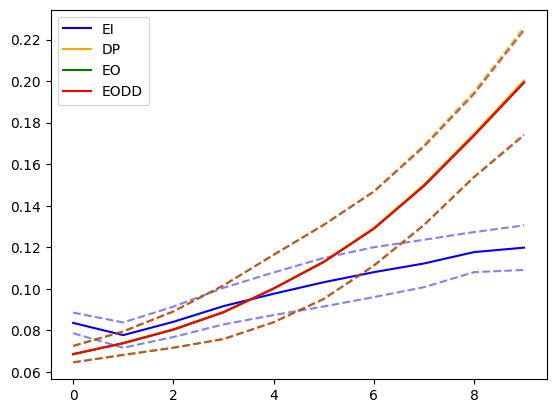

In [ ]:
EI_fairness_tl = np.mean(EI_fairness, axis=0)
timeline = range(seq_len)   
EI_top = EI_fairness_tl + np.std(EI_fairness, axis=0)
EI_bottom = EI_fairness_tl - np.std(EI_fairness, axis=0)
DP_fairness_tl = np.mean(DP_fairness, axis=0)
DP_top = DP_fairness_tl + np.std(DP_fairness, axis=0)
DP_bottom = DP_fairness_tl - np.std(DP_fairness, axis=0)
EO_fairness_tl = np.mean(EO_fairness, axis=0)
EO_top = EO_fairness_tl + np.std(EO_fairness, axis=0)
EO_bottom = EO_fairness_tl - np.std(EO_fairness, axis=0)
EODD_fairness_tl = np.mean(EODD_fairness, axis=0)
EODD_top = EODD_fairness_tl + np.std(EODD_fairness, axis=0)
EODD_bottom = EODD_fairness_tl - np.std(EODD_fairness, axis=0)

plt.plot(timeline, EI_top, color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EI_bottom,  color='blue', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EI_fairness_tl, color='blue', label='EI')
plt.plot(timeline, DP_top, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, DP_bottom, color='orange', linestyle='dashed', alpha=0.5)
plt.plot(timeline, DP_fairness_tl, color='orange', label='DP')
plt.plot(timeline, EO_top, color='green', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EO_bottom, color='green', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EO_fairness_tl, color='green', label='EO')
plt.plot(timeline, EODD_top, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EODD_bottom, color='red', linestyle='dashed', alpha=0.5)
plt.plot(timeline, EODD_fairness_tl, color='red', label='EODD')
plt.legend()
plt.show()

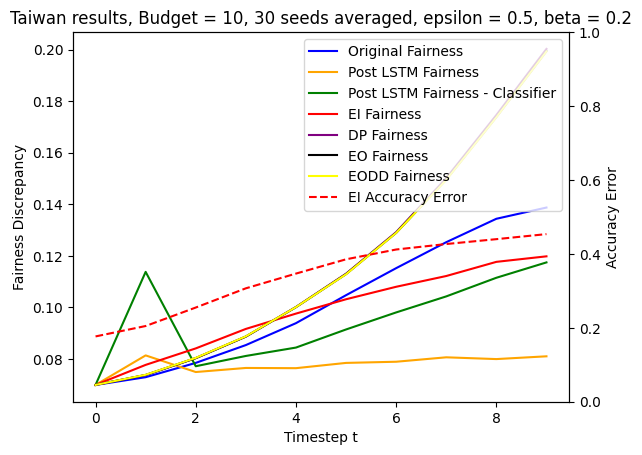

In [ ]:
timeline = range(seq_len)
dataset = 'taiwan'
EI_accuracy_tl = np.mean(EI_accuracy, axis=0)
EI_fairness_tl[0] = og_fairness_tl[0]
DP_fairness_tl[0] = og_fairness_tl[0]
EO_fairness_tl[0] = og_fairness_tl[0]
EODD_fairness_tl[0] = og_fairness_tl[0]
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(timeline, og_fairness_tl, color='blue', label='Original Fairness', marker = "*")

ax1.plot(timeline, model_fairness_tl_lstm, color='orange', label='Post LSTM Fairness', marker = "o")

ax1.plot(timeline, model_fairness_tl_lstm_clf, color='green', label='Post LSTM Fairness - Classifier', marker = "x")

ax1.plot(timeline, EI_fairness_tl, color='red', label='EI Fairness', marker = "s")
ax2.plot(timeline, EI_accuracy_tl, color='red', linestyle='dashed', label='EI Accuracy Error', scaley=False)
ax1.plot(timeline, DP_fairness_tl, color='purple', label='DP Fairness')
ax1.plot(timeline, EO_fairness_tl, color='black', label='EO Fairness')
ax1.plot(timeline, EODD_fairness_tl, color='yellow', label='EODD Fairness')
plt.title(f'Taiwan results, Budget = {budget}, 30 seeds averaged, epsilon = {epsilon}, beta = {b}')
ax1.set_xlabel('Timestep t')
ax1.set_ylabel('Fairness Discrepancy')
ax2.set_ylabel('Accuracy Error')

handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

plt.legend(handles1 + handles2, labels1 + labels2)
plt.savefig("Taiwan Results - 30 seeds averaged budget = " + str(budget) + ", epsilon = "+eps+", beta = "+bet+".png")
plt.show()

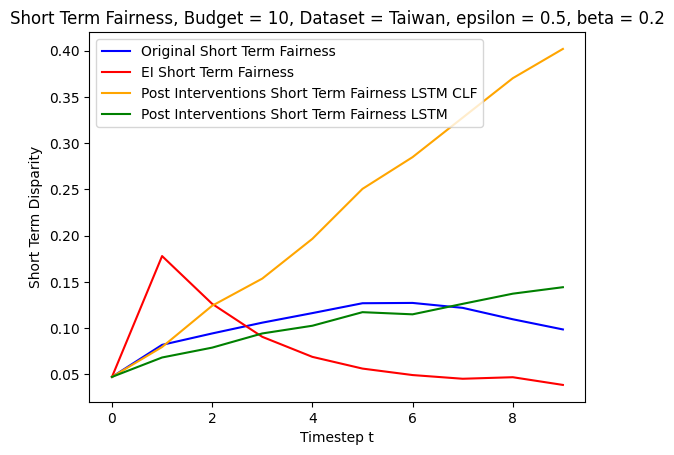

In [ ]:
EI_short_tl = np.mean(EI_short_term, axis=0)
DP_short_tl = np.mean(DP_short_term, axis=0)
EO_short_tl = np.mean(EO_short_term, axis=0)
EODD_short_tl = np.mean(EODD_short_term, axis=0)
EI_short_tl[0] = og_short_term_tl[0]
DP_short_tl[0] = og_short_term_tl[0]
EO_short_tl[0] = og_short_term_tl[0]
EODD_short_tl[0] = og_short_term_tl[0]
plt.plot(timeline, og_short_term_tl, color='blue', label='Original Short Term Fairness', marker = "*")
plt.plot(timeline, EI_short_tl, color='red', label='EI Short Term Fairness', marker = "s")
plt.plot(timeline, short_term_clf_tl, color='orange', label='Post Interventions Short Term Fairness LSTM CLF', marker = "x")
plt.plot(timeline, short_term_lstm_tl, color='green', label='Post Interventions Short Term Fairness LSTM', marker = "o")
plt.title(f'Short Term Fairness, Budget = {budget}, Dataset = Taiwan, epsilon = {epsilon}, beta = {b}')
plt.xlabel('Timestep t')
plt.ylabel('Short Term Disparity')
plt.legend()
plt.savefig("Taiwan Short Term Results - 30 seeds averaged budget = " + str(budget) + ", epsilon = "+eps+", beta = "+bet+".png")
plt.show()

In [ ]:
data_path = Path('../data')
file_path = '/home/fagumuci/Long-Term-EI/Long-Term-Equal-Improvability/SimLoan/data/default of credit card clients.xls'
df = pd.read_excel(file_path, header=1)
df = df[(df['PAY_AMT1'] < 10000) & (df['PAY_AMT1'] > 10)]
df = df[(df['PAY_AMT2'] < 10000) & (df['PAY_AMT2'] > 10)]
df = df[(df['PAY_AMT3'] < 10000) & (df['PAY_AMT3'] > 10)]

label0 = df[(df['default payment next month'] == 1) & (df['SEX'] == 1)].sample(n=1000, replace=False, random_state=2021)
label1 = df[(df['default payment next month'] == 0) & (df['SEX'] == 1)].sample(n=1000, replace=False, random_state=2021)
label2 = df[(df['default payment next month'] == 1) & (df['SEX'] == 2)].sample(n=1000, replace=False, random_state=2021)
label3 = df[(df['default payment next month'] == 0) & (df['SEX'] == 2)].sample(n=1000, replace=False, random_state=2021)

df = pd.concat([label0, label1, label2, label3], axis=0)
X = df.iloc[:, 18:20].apply(lambda x: 3 * (x - x.min()) / (x.max() - x.min()))
Z = df.iloc[:, 1:2].apply(lambda x: 3 * (x - x.min()) / (x.max() - x.min()))
S = df['SEX'] - 1
Y = df['default payment next month'].replace({0: 1, 1: 0})
data = pd.concat([S, Z, X, Y], axis=1)

data = data.rename(columns={'default payment next month': 'y'})

: 